In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import matplotlib.cbook
import matplotlib as mpl
import matplotlib.image as mpimg
import time
import itertools
import seaborn as sns
import os
import json
from sympy import *
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.fftpack import rfft,fft,fftfreq,rfftfreq
from scipy.signal import medfilt, find_peaks
from scipy.io import loadmat
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit,brute,basinhopping
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
import math
from itertools import combinations
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from string import ascii_uppercase as abc; abc = abc
try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm_notebook as tqdm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from itertools import compress, product
import random
from scipy.interpolate import InterpolatedUnivariateSpline as spline_interp
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patheffects as PathEffects
from matplotlib.gridspec import GridSpec

matplotlib_axes_logger.setLevel('ERROR')
np.seterr(divide='ignore', invalid='ignore')

def_color  = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

init_printing()
plt.rc('font', size=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=8) 
matplotlib.rcParams["figure.dpi"] = 100

In [2]:
def remove_top_right_frame(axes):
    for ax in axes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

def remove_axe_labels(ax):
    ax.set_title('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
        
def to_dict(keys,values):
    return dict(zip(keys,values))

def get_test_dataframe(path,file):
    tdf       = pd.read_csv(path+file)
    tdf.index = np.array([np.array(s.replace('[','').replace(')','').split(',')).astype(int).mean() for s in tdf['week']])
    tdf       = tdf.drop(columns=['week'])
    tdf.rename(columns={"age50": "age"},inplace=True)
    if len(tdf)<140:
        missing_index = np.sort(list(set(np.arange(-59.5,80.5,1)) - set(tdf.index)))
        tdf = tdf.T
        [tdf.insert(int(np.argwhere(np.arange(-59.5,80.5,1) == missing_index[i])[0][0]),missing_index[i],np.nan) for i in range(len(missing_index))]
        tdf = tdf.T
    return tdf

# Loading the dataset

In [3]:
path     = '../Clalit Data/pregnancy.1w/'
files    = [file for file in os.listdir(path)]
all_tests= [file.split('.')[0] for file in files]
dfs      = dict(zip(all_tests,[get_test_dataframe(path,file) for file in files]))

# Loading metadata

In [4]:
'''
Code to create dataframe of tests values by percentile from LabNorm package in R (https://github.com/tanaylab/labNorm)

library(labNorm)
df1 = data.frame()
df2 = data.frame()

for (idx in 1:93) {
  dat1<-ln_quantile_value(c(0,0.01,0.03,0.10,0.15,0.25,0.35,0.50,0.65,0.75,0.85,0.90,0.97,0.99,1), seq(20, 40, by = 1), "female", LAB_DETAILS$short_name[idx])
  df1 <- rbind(df, dat1)}

write.csv(df1,file='D:/Alon/AlonProjects/pregnancy/LabNorm.csv', row.names=FALSE)
'''
groups        = ['Liver','Renal','Musculoskeletal','Metabolism','RBCs','Coagulation','Immune','Endocrine']
subgroups_main= ['Liver','Renal I','Renal II','Musculoskeletal','Metabolism','RBCs I','RBCs II','Coagulation','Immune I','Immune II','Endocrine']
subgroups_si  = ['Liver','Renal I','Renal II','Musculoskeletal','Metabolism','RBCs I','RBCs II','RBCs III','Coagulation','Immune I','Immune II','Immune III','Endocrine I','Endocrine II','Endocrine III']
metadata      = pd.read_excel('../Files/Metadata.xlsx',index_col=0)#.drop(remove)
labnorm       = pd.read_csv('../Files/LabNorm.csv')
labnorm_tests = list(metadata.loc[~metadata['LabNorm name'].isna()].index)

# Functions to process the data

In [5]:
def get_age_matched_reference(test):
    age  = int(np.nanmedian(dfs[test]['age']))
    tdf  = labnorm.loc[(labnorm.age==age)&(labnorm.lab==metadata.loc[test]['LabNorm name'])].fillna(method='ffill').fillna(method='bfill').copy()
    tdf['value'].loc[tdf.value<0] = np.min(tdf['value'].loc[tdf.value>0])
    prob = np.diff(tdf['quantile'])/np.sum(np.diff(tdf['quantile']))
    mu_  = (tdf.value.iloc[1:]*prob).sum()
    sd_  = np.sqrt((prob*((tdf.value.iloc[1:] - mu_)**2)).sum())
    q_to_val = interp1d(tdf['quantile'],tdf['value'],kind='linear')
    return {'quantile':q_to_val,'mean':mu_,'sd':sd_}

def get_mean_stats(test):
    tdf = dfs[test]
    n   = tdf['n']
    v   = tdf['mean']
    e   = tdf['sd']/np.sqrt(tdf['n'])
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_quantile_stats(test):
    tdf = dfs[test]
    n   = tdf['n']
    v   = tdf['qmean']
    e   = (tdf['qq75'] - tdf['qq25'])/(np.sqrt(tdf['n'])*0.675*2)
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_value_at_quantile_stats(test):
    tdf = get_quantile_stats(test)
    if test in labnorm_tests:
        ref = get_age_matched_reference(test)
        v   = ref['quantile'](tdf['value'])
        e_p = ref['quantile'](tdf['value']+tdf['error'])
        e_m = ref['quantile'](tdf['value']-tdf['error'])
        e   = ((e_p - v) + (v-e_m))/2
        return pd.DataFrame(np.array([tdf['n'],v,e]).T,index=tdf.index,columns=['n','value','error'])
    else:
        return pd.DataFrame(index=tdf.index,columns=['n','value','error'])

def get_postpartum_SDS_stats(test):
    df       = get_quantile_stats(test)
    df['sd'] = df['error']*np.sqrt(df['n'])    
    mu_end   = np.sum(df.loc[70:]['n']*df.loc[70:]['value'])/(np.sum(df.loc[70:]['n']))
    sd_end   = np.sqrt(np.sum(df.loc[70:]['n']*df.loc[70:]['sd']**2)/(np.sum(df.loc[70:]['n'])))    
    v        = (df['value'] - mu_end) / sd_end
    e        = df['error'] / sd_end
    return pd.DataFrame(np.array([df['n'],v,e]).T,index=df.index,columns=['n','value','error']).loc[0:]    
     
def get_test_data(test):
    return {'mean'             :get_mean_stats(test),
            'quantile'         :get_quantile_stats(test),
            'value_at_quantile':get_value_at_quantile_stats(test),
            'postpartum_SDS'   :get_postpartum_SDS_stats(test)}

def get_stats_from_dataset(test,stat,period=[-60,80],merge_timepoints = True):
    
    df       = data[test][stat].copy()
    df['sd'] = df['error']*np.sqrt(df['n'])
 
    split_k = 1
    if merge_timepoints:
        split_k  = np.min([int(np.ceil(np.nanmean((df['error']/(df['value'].std() * 0.15))**2))),7])
        
        if split_k > 1:
            df     = df.reset_index()
            splits = np.array_split(df, int(len(df)/split_k))
            x      = np.array([tdf['index'].mean()                                   for tdf in splits])
            n      = np.array([tdf['n'].sum()                                        for tdf in splits])
            v      = np.array([np.sum(tdf['value']*tdf['n'])/tdf['n'].sum()          for tdf in splits])
            sd     = np.array([np.sqrt(np.sum(tdf['sd']**2*tdf['n'])/tdf['n'].sum()) for tdf in splits])
            e      = sd/np.sqrt(n)
            df     = pd.DataFrame(np.array([n,v,e]).T,columns=['n','value','error'],index=x)
   
    df = df.loc[period[0]:period[1]]
    x  = df.index
    n  = df.n
    v  = df['value']
    e  = df['error']
    return x,v,e,n    

In [6]:
data = {test:get_test_data(test) for test in tqdm(all_tests)}

  0%|          | 0/112 [00:00<?, ?it/s]

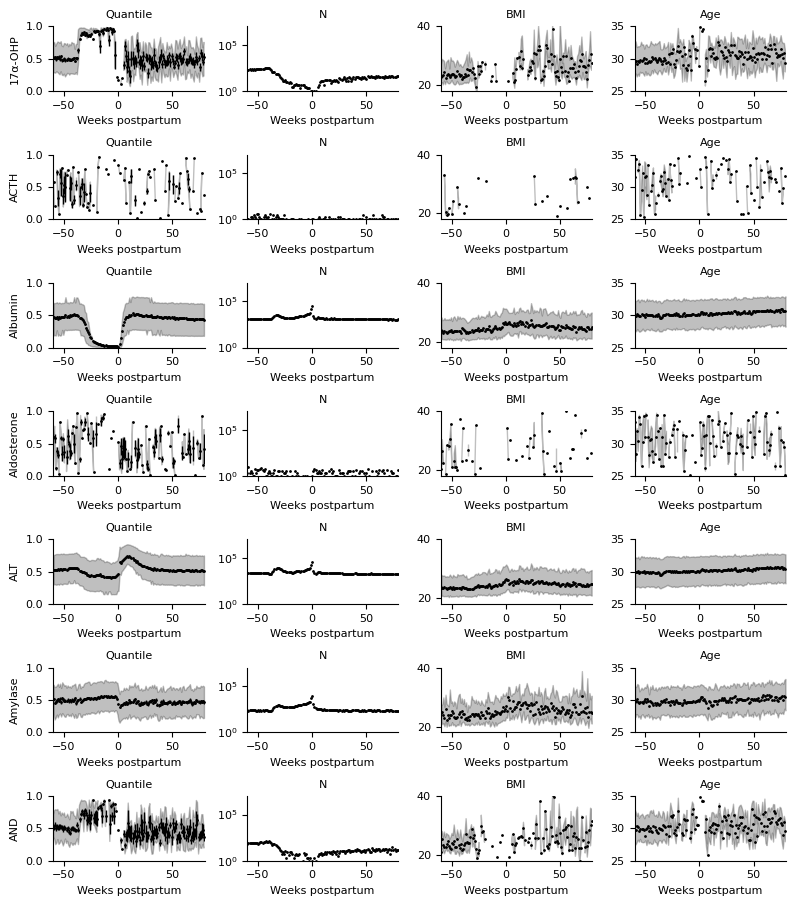

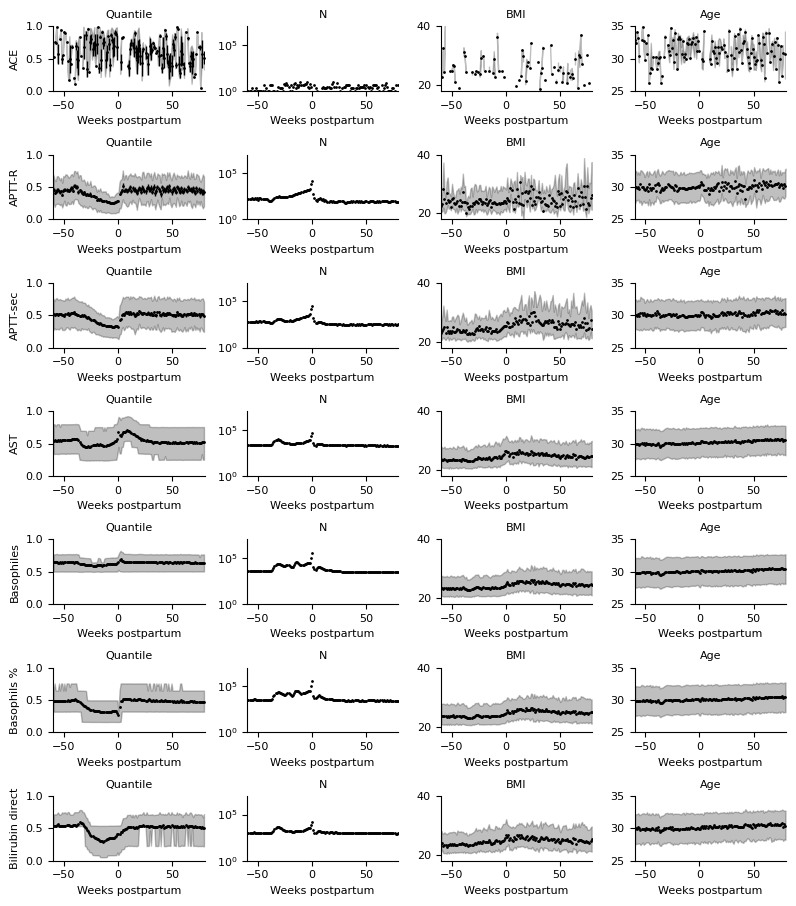

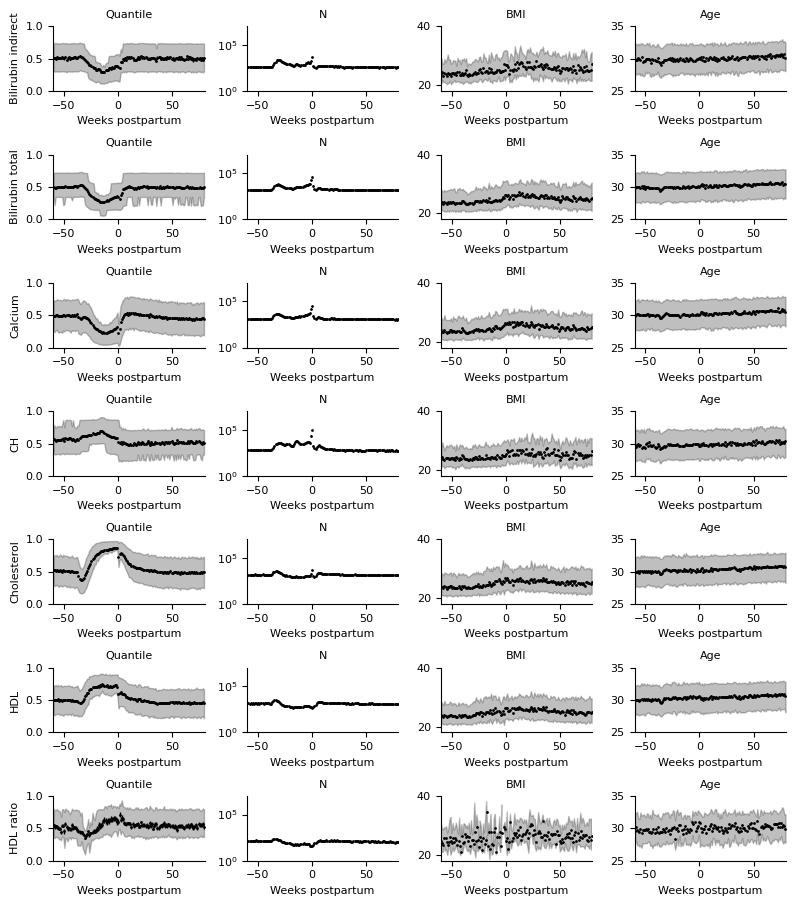

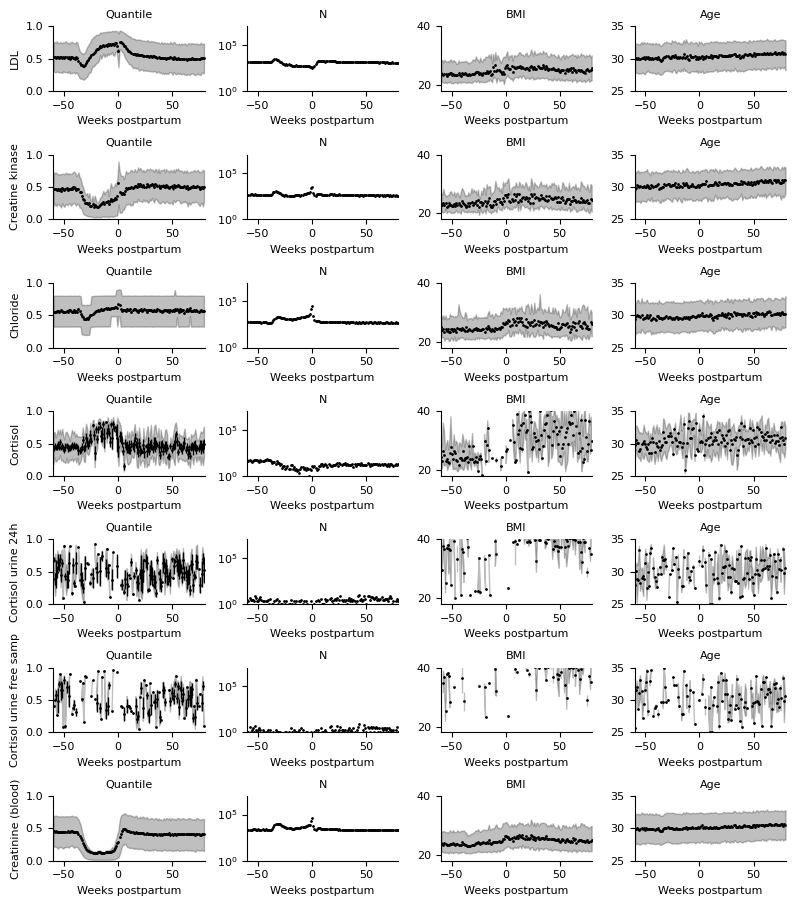

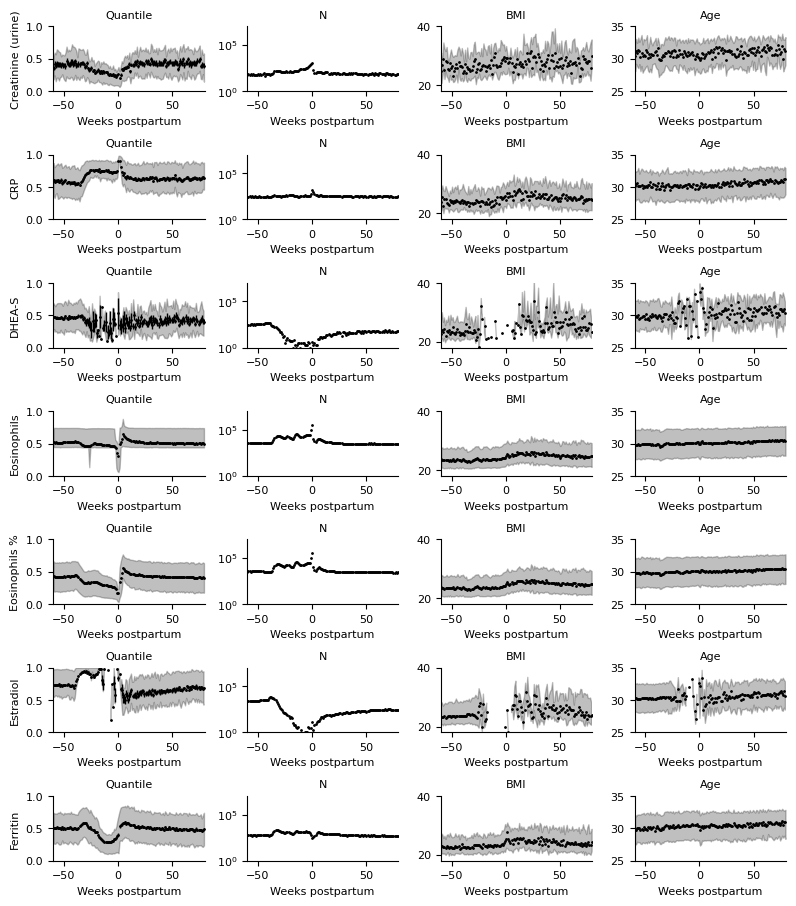

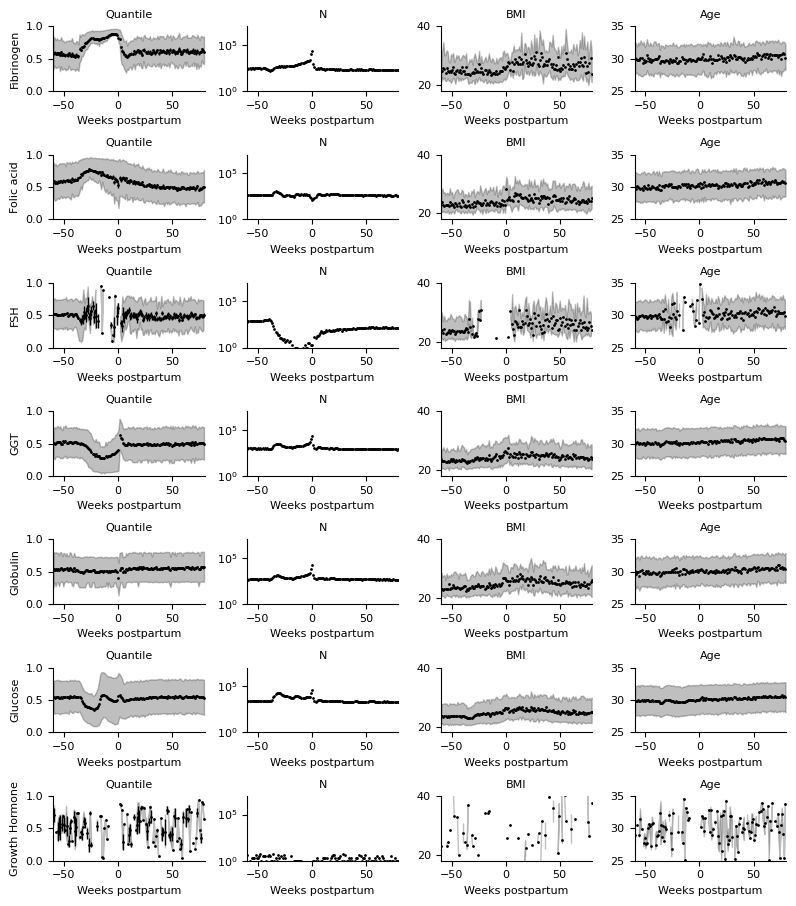

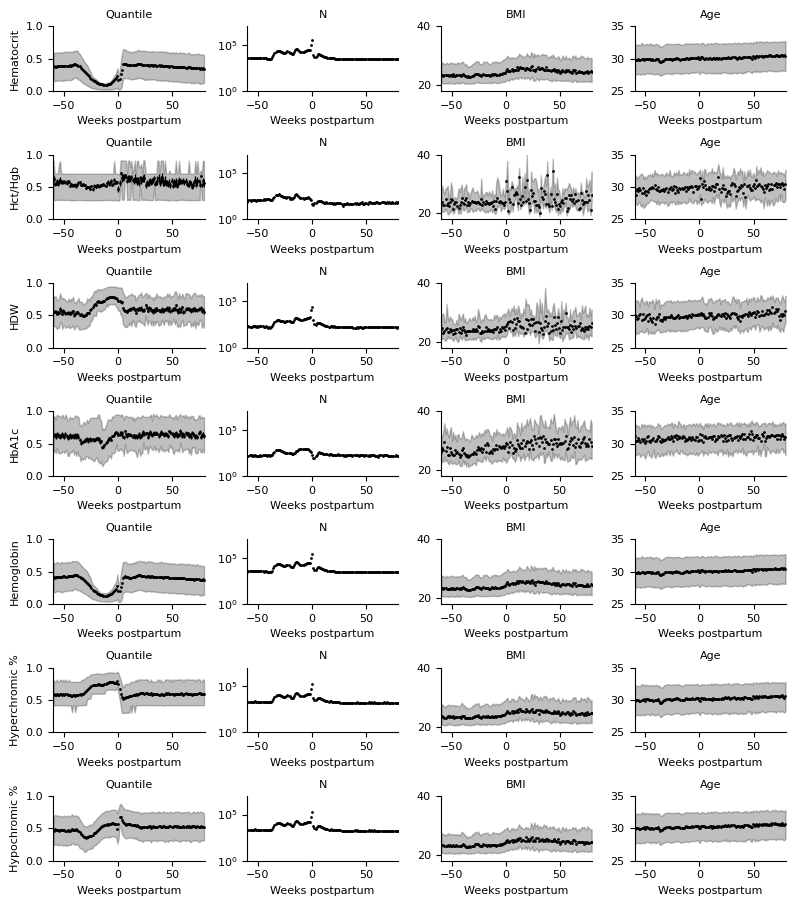

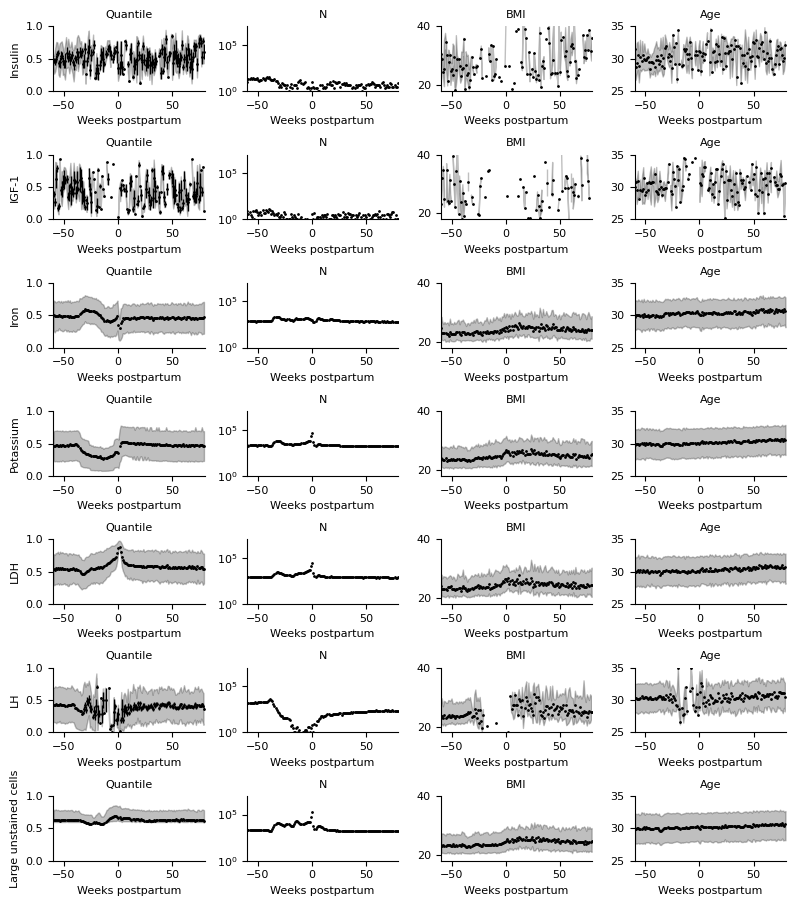

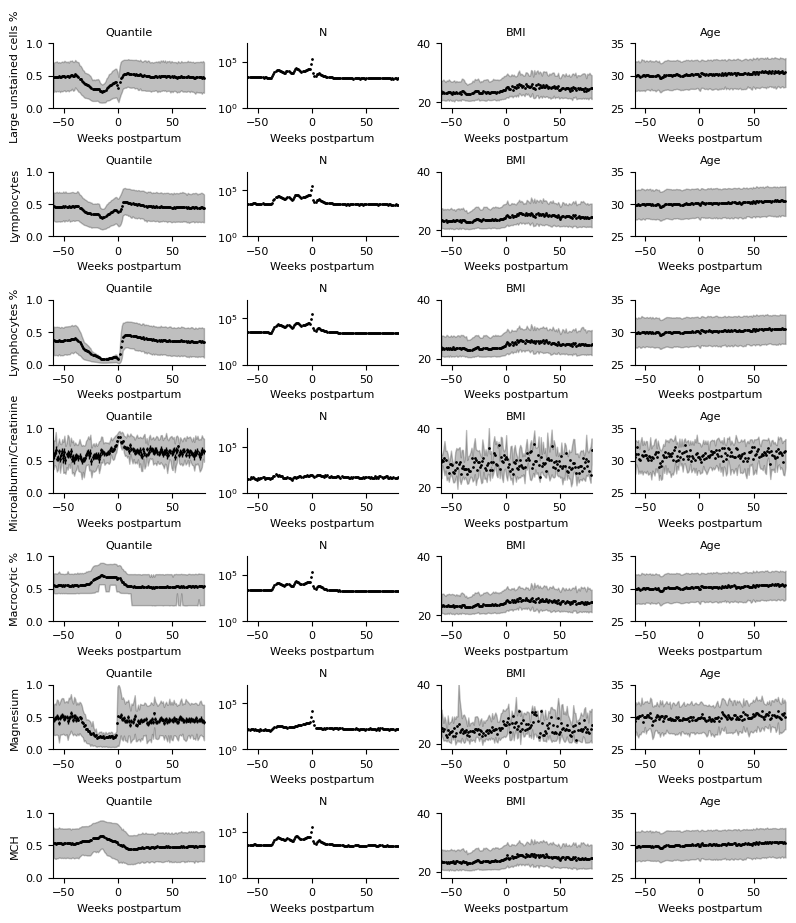

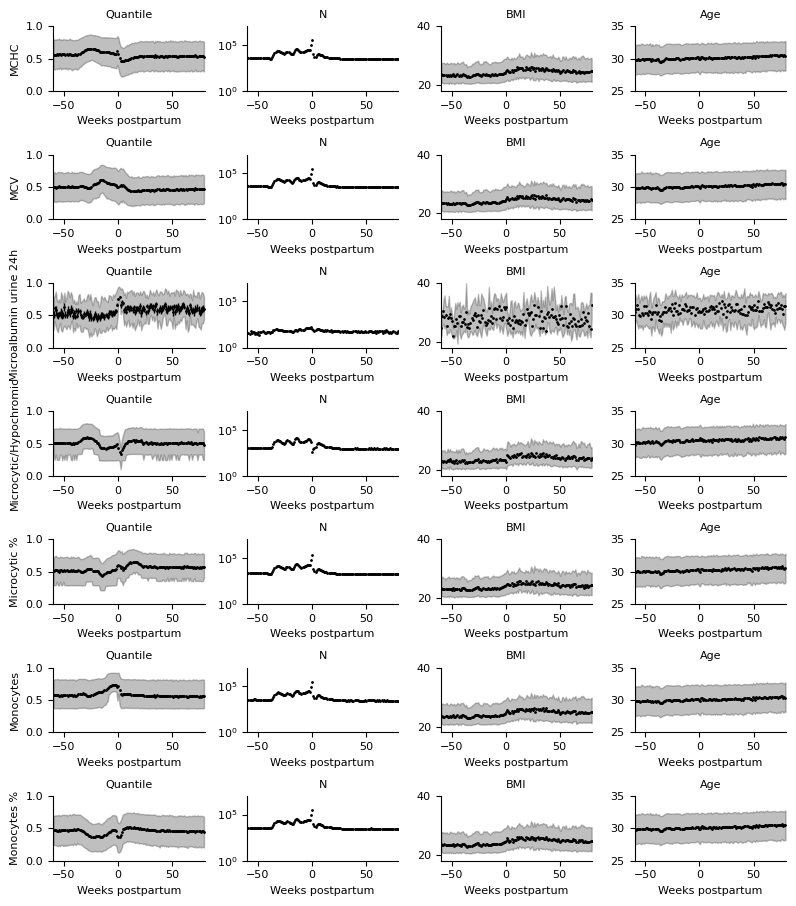

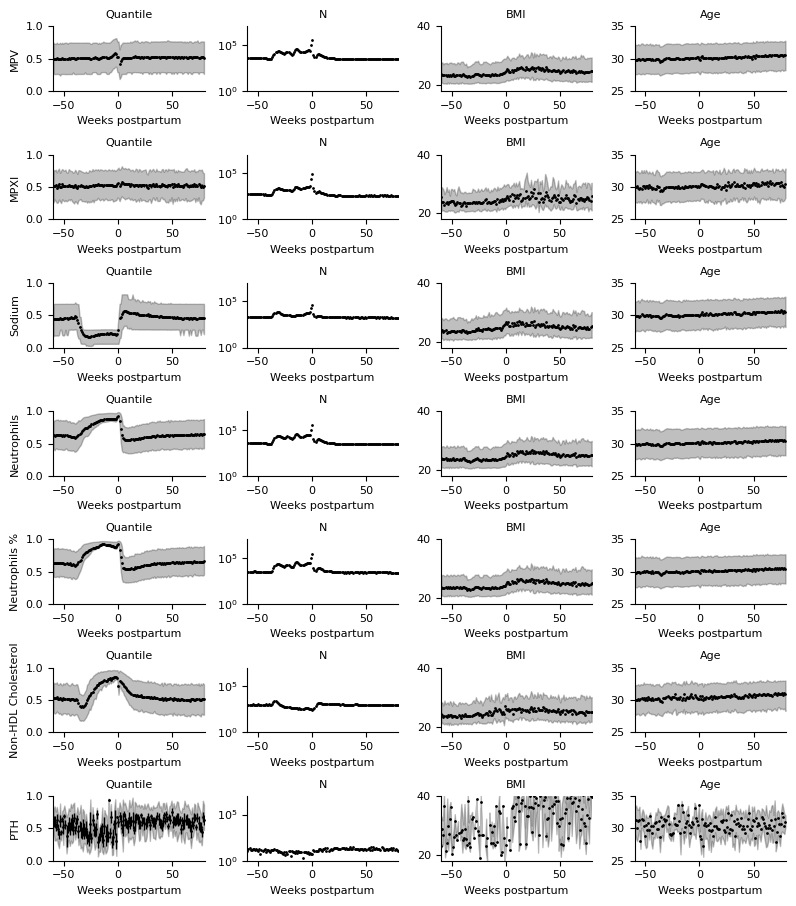

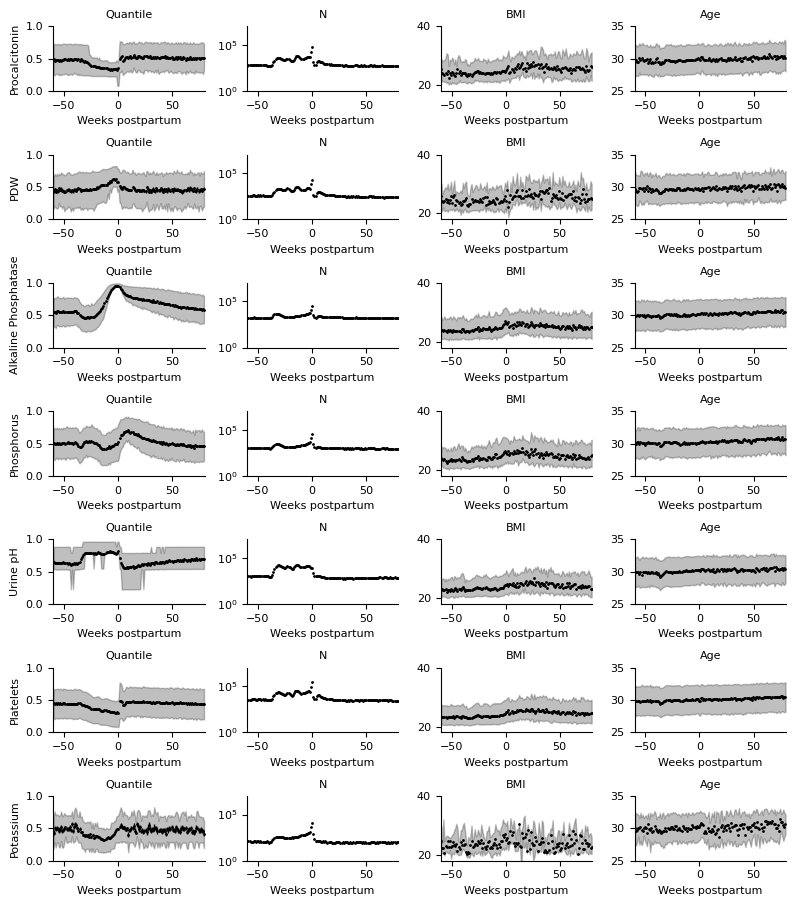

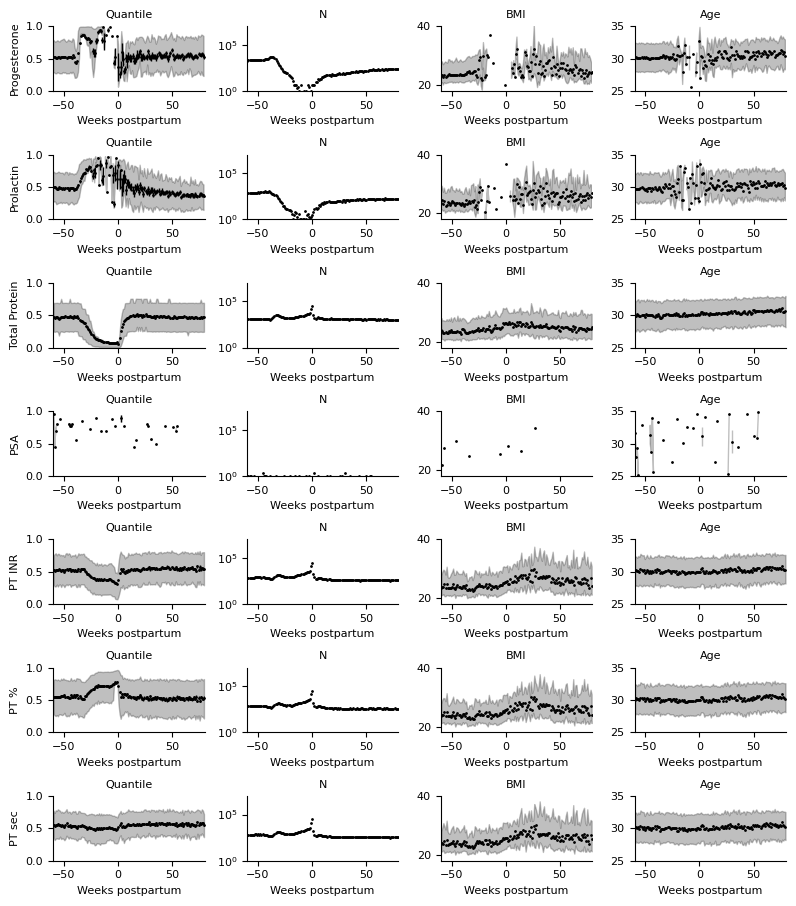

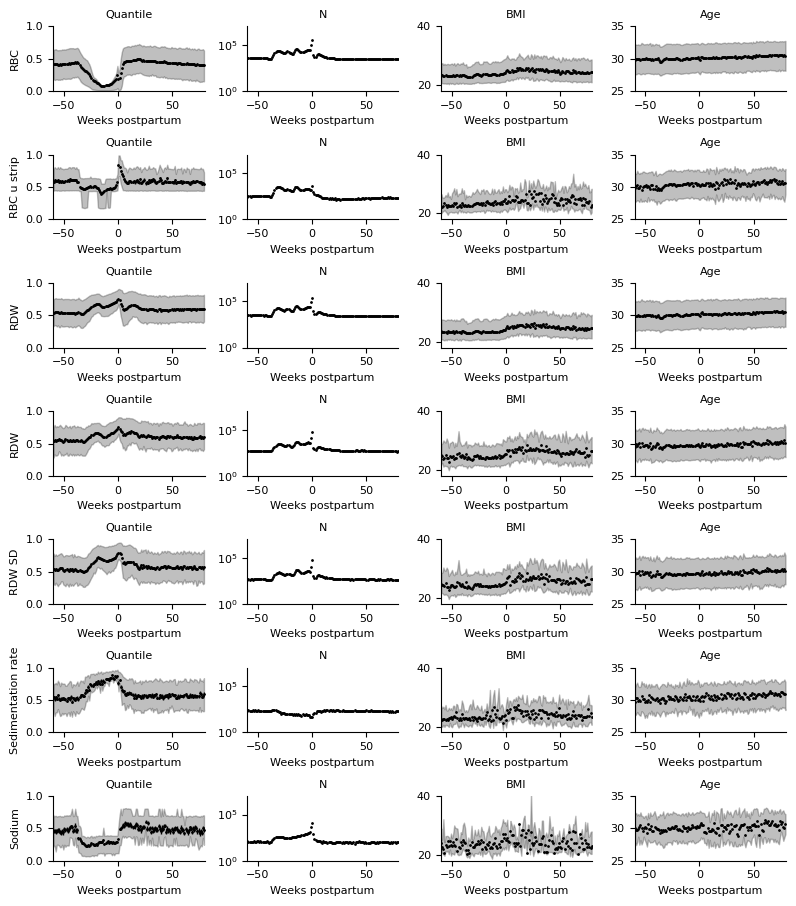

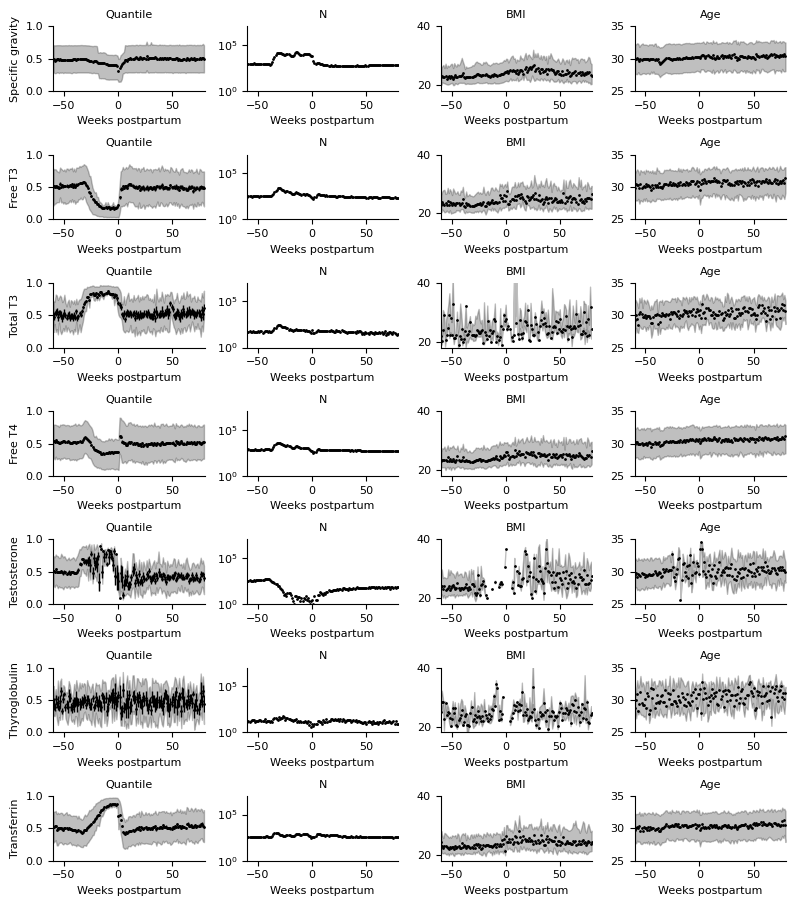

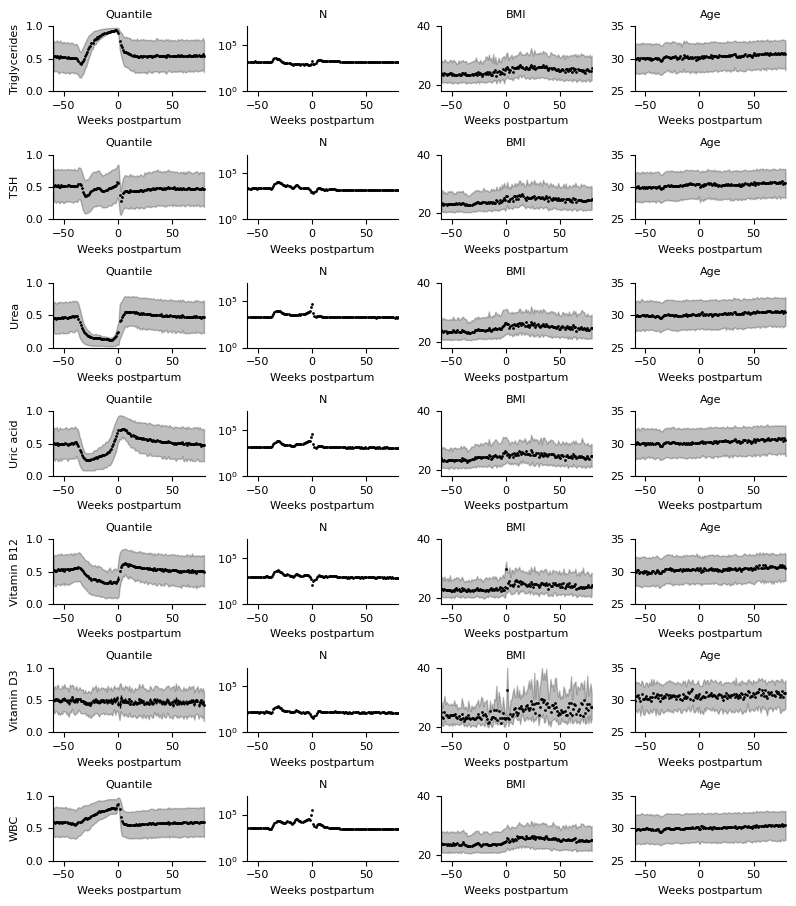

In [7]:
for j in range(len(all_tests)//7):
    
    tests = all_tests[j*7:j*7+7]
    plt.figure(figsize=(8,1.3*len(tests)))
    for i,test in enumerate(tests):
        ax1,ax2,ax3,ax4   = plt.subplot(len(tests),4,1+4*i),plt.subplot(len(tests),4,2+4*i),plt.subplot(len(tests),4,3+4*i),plt.subplot(len(tests),4,4+4*i)
        x,v,e,n           = get_stats_from_dataset(test,'quantile',merge_timepoints = False)
        bmi25,bmi50,bmi75 = dfs[test]['bmi25'],dfs[test]['bmi'],dfs[test]['bmi75']
        age25,age50,age75 = dfs[test]['age25'],dfs[test]['age'],dfs[test]['age75']

        ax1.errorbar(x,v,e,fmt='o',markersize=1,c='k',elinewidth=1); ax1.set_title('Quantile'); ax1.set_xlabel('Weeks postpartum')
        ax2.plot(x,n,marker='o',markersize=1,c='k',lw=0)           ; ax2.set_title('N')       ; ax2.set_xlabel('Weeks postpartum')
        ax3.plot(x,bmi50,marker='o',markersize=1,c='k',lw=0)       ; ax3.set_title('BMI')     ; ax3.set_xlabel('Weeks postpartum')
        ax4.plot(x,age50,marker='o',markersize=1,c='k',lw=0)       ; ax4.set_title('Age')     ; ax4.set_xlabel('Weeks postpartum')

        ax1.fill_between(x,dfs[test]['qq25'],dfs[test]['qq75'],alpha=0.25,color='k')
        ax3.fill_between(x,bmi25,bmi75,alpha=0.25,color='k')
        ax4.fill_between(x,age25,age75,alpha=0.25,color='k')

        ax1.set_ylim([0,1])   ; ax1.set_xlim([-60,80])
        ax2.set_ylim([10e-1,10e6])   ; ax2.set_xlim([-60,80]); ax2.set_yscale('log')
        ax3.set_ylim([18,40]) ; ax3.set_xlim([-60,80])
        ax4.set_ylim([25,35]) ; ax4.set_xlim([-60,80])

        ax1.set_ylabel(metadata.loc[test]['Nice name'])
        remove_top_right_frame([ax1,ax2,ax3,ax4])
    plt.tight_layout();
    plt.savefig('S_1_'+str(j)+'.jpg',bbox_inches = 'tight',dpi=300);
    plt.show() 


# We focus on 78 of the tests for our analysis

In [8]:
tests = pd.read_csv('../Files/tests_in_analysis.csv',index_col=0).values.flat[:]

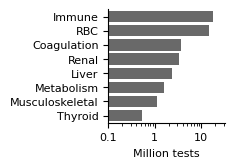

In [9]:
ndf          = pd.DataFrame([dfs[test]['n'] for test in tests],index=tests).fillna(0).astype(int)
tdf          = pd.DataFrame(index=tests)
tdf['n']     = ndf.sum(axis=1)
tdf['group'] = metadata['Group']

temp          = pd.DataFrame([tdf.loc[tdf['group'] == group]['n'].sum() for group in groups],index=groups,columns=['n'])
temp['group'] = temp.index
temp          = temp.sort_values(by=['n'],ascending=False)
temp['group'].iloc[1] = 'RBC'
temp['group'].iloc[-1] = 'Thyroid'

plt.figure(figsize=(1.5,1.5))
ax = plt.subplot(111)
sns.barplot(data=temp,y='group',x='n',ax=ax,orient='h',color='dimgray')
ax.set_ylabel('')
ax.set_xscale('log')
ax.set_xlim([10**5,10**7.5])
ax.set_xticklabels(['','0.1','1','10'])
ax.set_xlabel('Million tests')
remove_top_right_frame([ax])
plt.savefig('M_1A.pdf',bbox_inches = 'tight',dpi=300)
plt.show()

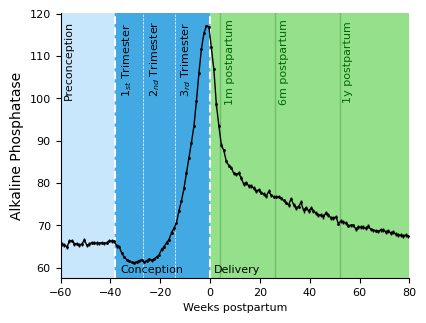

In [10]:
test      = 'PHOSPHATASE_ALKALINE'
stat      = 'value_at_quantile'
x,v,e,n   = get_stats_from_dataset(test,stat)
ref       = get_age_matched_reference(test)
ref_val   = ref['quantile'](0.5)
ylabel    = 'Value at mean quantile'
ref_label = "Reference Population Median"

plt.figure(figsize=(4.5,3.5))    
ax      = plt.subplot(111)
ax.errorbar(x,v,e,c='k',lw=1,fmt='-o',markersize=1,zorder=-3)
ax.set_xticks(np.arange(-60,100,20))
ax.set_xlabel('Weeks postpartum')
ax.set_ylabel(metadata.loc[test]['Nice name'],fontsize=10)# + ylabel)
ax.set_xlim([-60,80])
ax.set_ylim(ax.get_ylim()[0]*0.99,ax.get_ylim()[1])
ax.axvspan(-60,-38,color='#C8E7FD',zorder=-5)
ax.axvspan(-38,0,color='#43A9E2',zorder=-5)
ax.axvspan(0,80,color='#95E08B',zorder=-5)
ax.axvline(x=4,c='darkgreen',ls='-',zorder=-3,lw=1,alpha=0.25)
ax.axvline(x=26,c='darkgreen',ls='-',zorder=-3,lw=1,alpha=0.25)
ax.axvline(x=52,c='darkgreen',ls='-',zorder=-3,lw=1,alpha=0.25)
ax.axvline(x=-27,c='white',ls='--',zorder=-4,lw=0.5)
ax.axvline(x=-14,c='white',ls='--',zorder=-4,lw=0.5)
ax.axvline(x=-38,c='white',ls='--',zorder=-4)
ax.axvline(x=0,c='white',ls='--',zorder=-4)
ax.annotate('1m postpartum',xy=(0.47,0.66),xycoords='axes fraction',rotation = 90,c='darkgreen',alpha=0.99)
ax.annotate('6m postpartum',xy=(0.625,0.66),xycoords='axes fraction',rotation = 90,c='darkgreen',alpha=0.99)
ax.annotate('1y postpartum',xy=(0.81,0.67),xycoords='axes fraction',rotation = 90,c='darkgreen',alpha=0.99)
ax.annotate('Preconception',xy=(0.01,0.68),xycoords='axes fraction',rotation = 90,alpha=0.99)
ax.annotate('$1_{st}$ Trimester',xy=(0.17,0.7),xycoords='axes fraction',rotation = 90,alpha=0.99)
ax.annotate('$2_{nd}$ Trimester',xy=(0.25,0.7),xycoords='axes fraction',rotation = 90,alpha=0.99)
ax.annotate('$3_{rd}$ Trimester',xy=(0.34,0.7),xycoords='axes fraction',rotation = 90,alpha=0.99)
ax.annotate('Conception',xy=(0.17,0.02),xycoords='axes fraction',alpha=0.99)
ax.annotate('Delivery',xy=(0.44,0.02),xycoords='axes fraction',alpha=0.99)
remove_top_right_frame([ax])
plt.savefig('M_1B.pdf',bbox_inches = 'tight',dpi=300); plt.show()

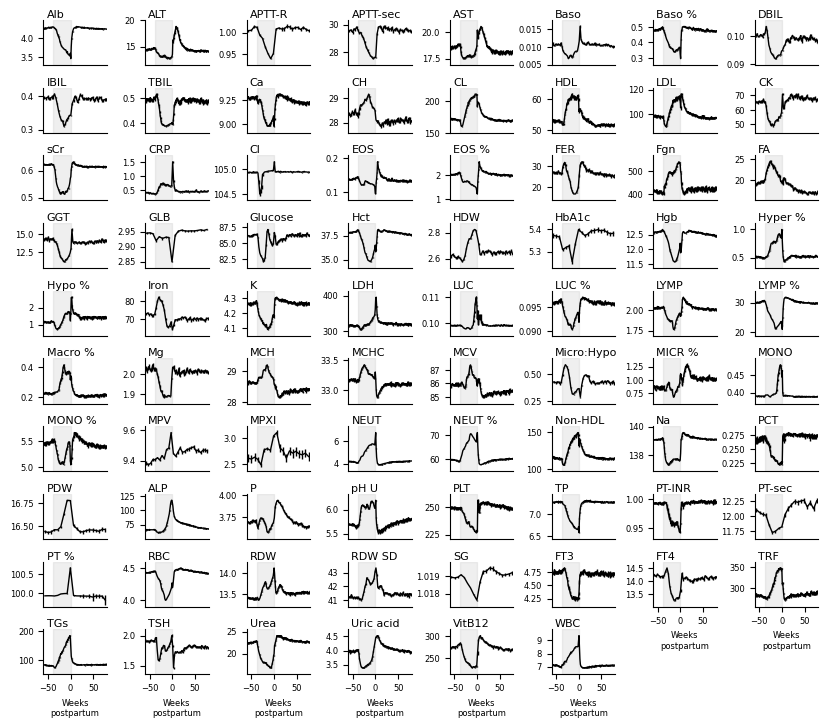

In [11]:
def plot_qunatile_change(ax,test):
    qstd   = pd.DataFrame([data[test]['value_at_quantile']['value'].std() for test in tests],index = tests)


    x,v,e,n = get_stats_from_dataset(test,'value_at_quantile')
    
    ylim_   = np.max(v) + (np.max(v)-np.min(v))*0.2
    ylim_1  = np.min(v) - (np.max(v)-np.min(v))*0.2
    
    ax.errorbar(x,v,e,c='k',lw=1)
    # ax.set_ylabel('Percentile\nChange',fontsize=6); 

    ax.set_ylim([ylim_1,ylim_])
    ax.set_xticks(np.arange(-50,100,50)) ; ax.set_xlabel('Weeks\npostpartum',fontsize=6); ax.set_xlim([-60,80])
    ax.axvspan(-38,0,color='dimgray',alpha=0.1,zorder=-20)

    ax.set_facecolor('w')
    remove_top_right_frame([ax])
    ax.annotate(metadata.loc[test]['Short name'],(0.05,1.05),xycoords='axes fraction',fontsize=8,color='k')
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.figure(figsize=(10,np.ceil(len(tests))/9))
for i,test in enumerate(tests):
    ax    = plt.subplot(int(np.ceil(len(tests)/8)),8,i+1)
    plot_qunatile_change(ax,test)
    
    if i<len(tests)-8:
        ax.set_xticks([])
        ax.set_xlabel('')
    if np.mod(i,8) != 0:
        ax.set_ylabel('')
    
plt.subplots_adjust(hspace=0.5,wspace=0.6);
plt.savefig('M_1C.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300);
plt.show()    

In [12]:
cols = ['n', 'Mean', 'Median', 'SD', 
         'Age (mean)', 'Age (25th percentile)', 'Age (25th percentile)',
         'BMI (mean)', 'BMI (25th percentile)', 'BMI (25th percentile)',
         'raw (25th percentile)','raw (75th percentile)',
         'Quantile (mean)','Quantile (median)','Quantile (25th percentile)','Quantile (75th percentile)',
         'Value at Quantile (mean)','Value at Quantile (SEM)','Value at Quantile (25th percentile)','Value at Quantile (75th percentile)']

with pd.ExcelWriter('SI_atlas_mini.xlsx') as writer:  
    for test in tests:
        temp = data[test]['value_at_quantile'].copy()
        ref  = get_age_matched_reference(test)
        p25  = ref['quantile'](dfs[test]['qq25'])
        p75  = ref['quantile'](dfs[test]['qq75'])
        temp['q25'] = p25
        temp['q75'] = p75
        tdf = pd.concat((dfs[test],temp.drop(columns=['n'])),axis=1)
        tdf.columns = cols
        tdf.to_excel(writer,sheet_name=metadata.loc[test]['Nice name'].replace(':', '').replace('/', ''))  

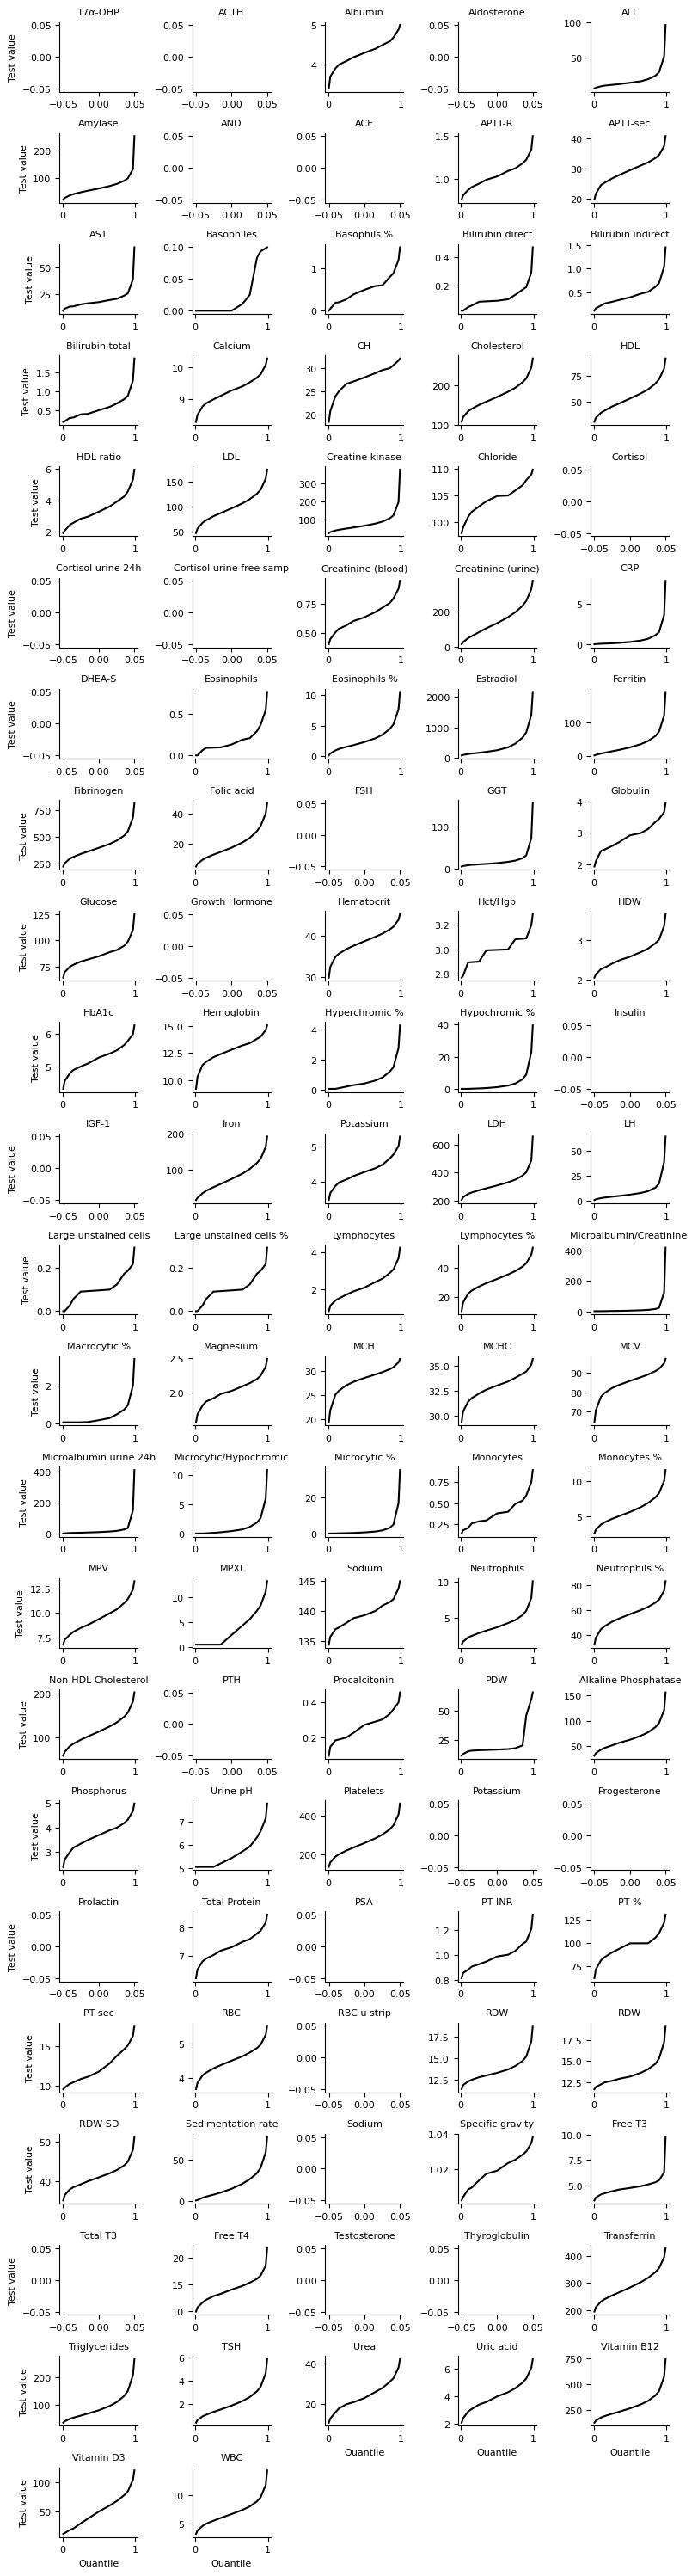

In [13]:
def plot_normlab(tests,age=30):
    nrow = 5
    plt.figure(figsize=(8,30))
    for i,test in enumerate(tests):
        ax  = plt.subplot(int(np.ceil(len(tests)/nrow)),nrow,i+1)
        tdf = labnorm.loc[(labnorm.age==30)&(labnorm.lab==metadata.loc[test]['LabNorm name'])].copy()
        tdf['value'].loc[tdf.value<0] = np.min(tdf['value'].loc[tdf.value>0])
        ax.plot(tdf['quantile'],tdf['value'],c='k')
        ax.set_xlabel('Quantile')
        ax.set_ylabel('Test value')
        ax.set_title(metadata.loc[test]['Nice name'])
        remove_top_right_frame([ax])
        if i<len(tests)-nrow:
            ax.set_xlabel('')
        if np.mod(i,nrow) != 0:
            ax.set_ylabel('')
    plt.tight_layout(); 
    
plot_normlab(all_tests) 
plt.savefig('S_2.pdf',bbox_inches = 'tight',dpi=300)
plt.show()

# We analyze the main trends in the dataset

In [14]:
summery = []
for test in tqdm(tests):
    temp           = get_test_data(test)
    ref            = get_age_matched_reference(test)
        
    x,v,e,n        = get_stats_from_dataset(test,'quantile',merge_timepoints=True)    
    var_q          = v.max() - v.min()
    
    x,v,e,n        = get_stats_from_dataset(test,'mean',merge_timepoints=True)
    relative_range = (v.max() - v.min())/ np.mean(v.iloc[:10])
    
    ref_cv         = ref['sd']/ref['mean']
    summery.append([var_q,relative_range,ref_cv])
summery = pd.DataFrame(summery,columns=['quantile variation','percent change','reference CV'],index=tests)

  0%|          | 0/78 [00:00<?, ?it/s]

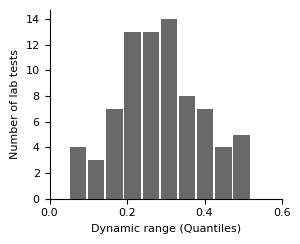

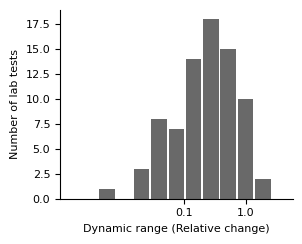

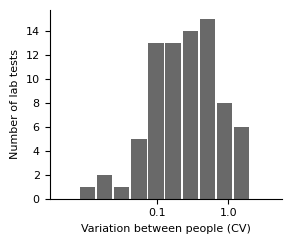

In [15]:
plt.figure(figsize=(3,2.5))
ax = plt.subplot(111)
summery['quantile variation'].hist(ax = ax,color='dimgray', zorder=2, rwidth=0.9)
ax.set_xlabel('Dynamic range (Quantiles)')
ax.set_ylabel('Number of lab tests')
ax.set_xticks([0,0.2,0.4,0.6])

ax.grid(False)
remove_top_right_frame([ax])
plt.savefig('M_2B.pdf',dpi=300,bbox_inches = 'tight',pad_inches=0.1); plt.show()
plt.show()

plt.figure(figsize=(3,2.5))
ax = plt.subplot(111)
np.log10(summery['percent change']).hist(ax = ax,color='dimgray', zorder=2, rwidth=0.9)
ax.set_xlabel('Dynamic range (Relative change)')
ax.set_ylabel('Number of lab tests')
ax.grid(False)
ax.set_xticks(np.arange(-1,4,1))
ax.set_xticklabels([str(float(10)**tick) for tick in ax.get_xticks()])
ax.set_xlim([-3,0.75])

remove_top_right_frame([ax])
# plt.savefig('percent_variation_hist.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

plt.figure(figsize=(3,2.5))
ax = plt.subplot(111)
np.log10(summery['reference CV']).hist(ax = ax,color='dimgray', zorder=2, rwidth=0.9)
ax.set_xlabel('Variation between people (CV)')
ax.set_ylabel('Number of lab tests')
ax.grid(False)
ax.set_xticks(np.arange(-1,4,1))
ax.set_xticklabels([str(float(10)**tick) for tick in ax.get_xticks()])
ax.set_xlim([-2.5,0.75])

remove_top_right_frame([ax])
# plt.savefig('reference_variation_hist.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

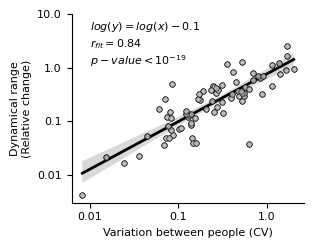

In [16]:
plt.figure(figsize=(3,2.5))
ax       = plt.subplot(111)
X,Y      = np.log10(summery.dropna()['reference CV']).values.reshape(-1, 1),np.log10(summery.dropna()['percent change']).values.reshape(-1, 1)
ax.scatter(X,Y,c='silver',s=15,edgecolor='k',lw=0.5)  
xlm,ylm  = ax.get_xlim(),ax.get_ylim()
xlm,ylm  = ax.get_xlim(),ax.get_ylim()

reg      = LinearRegression().fit(X,Y)
reg_line = [reg.coef_.flat[:]*xval +reg.intercept_.flat[:] for xval in np.arange(xlm[0],xlm[1],0.1)]
text     = '$log(y) = log(x) ' + str(np.round(reg.intercept_.flat[:][0],decimals=1)) + '$'
pearson_r   = np.round(stats.pearsonr(reg.predict(X).flat[:],Y.flat[:])[0],decimals=2)
pearson_pval= np.round(stats.pearsonr(reg.predict(X).flat[:],Y.flat[:])[1],decimals=5)

tdf = pd.DataFrame([np.log10(summery.dropna()['reference CV']),np.log10(summery.dropna()['percent change'])]).T
sns.regplot(ax=ax,x="reference CV", y="percent change", data=tdf,
            scatter_kws={"s": 15,"edgecolor":'k',"lw":0.5,"color":'silver'},
            line_kws={"color": "k","lw":2,"zorder":-5})

ax.annotate(text,(0-2,0.7))
ax.annotate('$r_{fit} = ' +str(pearson_r)+'$\n$p-value<10^{-19}$',(-2,0.05))

# ax.plot(np.arange(xlm[0],xlm[1],0.1),reg_line,c='gray',zorder=-4,lw=2)
ax.set_xlim(xlm);ax.set_ylim(ylm)
ax.set_xlabel('Variation between people (CV)')
ax.set_ylabel('Dynamical range\n(Relative change)')
ax.set_xticks(np.arange(-2,1,1))
ax.set_xticklabels([str(float(10)**tick) for tick in ax.get_xticks()])
ax.set_yticks(np.arange(-2,2,1))
ax.set_yticklabels([str(float(10)**tick) for tick in ax.get_yticks()])
remove_top_right_frame([ax])
plt.savefig('M_2A.pdf',dpi=300,bbox_inches = 'tight',pad_inches=0.1); plt.show()
plt.show()


Data normalziation and clustering using kmeams

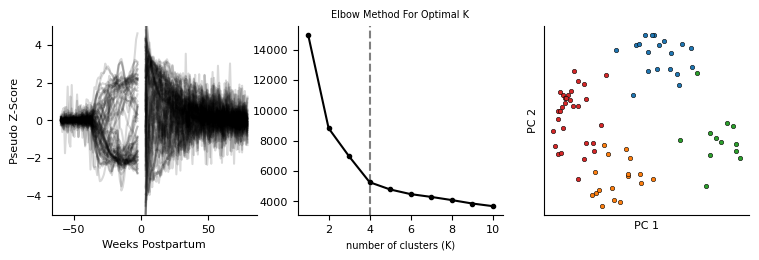

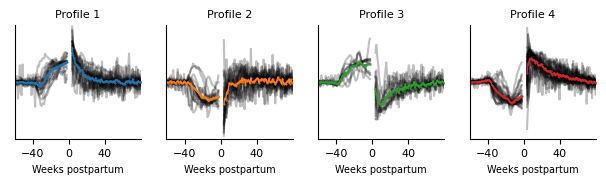

In [17]:
def get_pca_curve(test,preg_period,norm_baselines=True):
    # remove timepoints around delivery
    df       = get_test_data(test)['quantile'].drop(index=[-1.5,-0.5,0.5,1.5,2.5])
    df['sd'] = df['error']*np.sqrt(df['n'])

    ## norm end to start
    mu_end   = np.sum(df.loc[70:]['n']*df.loc[70:]['value'])/(np.sum(df.loc[70:]['n']))
    sd_end   = np.sqrt(np.sum(df.loc[70:]['n']*df.loc[70:]['sd']**2)/(np.sum(df.loc[70:]['n'])))
    mu_start = np.sum(df.loc[:-50]['n']*df.loc[:-50]['value'])/(np.sum(df.loc[:-50]['n']))
    sd_start = np.sqrt(np.sum(df.loc[:-50]['n']*df.loc[:-50]['sd']**2)/(np.sum(df.loc[:-50]['n'])))  

    mu          = pd.concat([(df['value'].loc[:0] - mu_start)/sd_start,(df['value'].loc[0:] - mu_end)/sd_end])
    err         = pd.concat([df['error'].loc[:0]/sd_start             ,df['error'].loc[0:]/sd_end])

    if norm_baselines:
        err.loc[0:] = err.loc[0:]/mu.loc[0:].std()
        err.loc[:0] = err.loc[:0]/mu.loc[:0].std()
        mu.loc[0:]  = mu.loc[0:]/mu.loc[0:].std()
        mu.loc[:0]  = mu.loc[:0]/mu.loc[:0].std()

    w_start, w_end = preg_period
    x   =  df.loc[w_start:w_end].index.values
    mu  =  mu.loc[w_start:w_end]
    err =  err.loc[w_start:w_end]
    return x,mu,err

zdf = pd.DataFrame([get_pca_curve(test,[-60,80])[1] for test in tests],index=tests).T.fillna(method ='backfill')
plt.figure(figsize=(9,2.5))
ax  = plt.subplot(131)
zdf.loc[:0].plot(legend=False,c='k',alpha=0.15,ax=ax)
zdf.loc[0:].plot(legend=False,c='k',alpha=0.15,ax=ax)
ax.set_xlabel('Weeks Postpartum',fontsize=8)
ax.set_ylabel('Pseudo Z-Score',fontsize=8)
ax.set_ylim([-5,5])
remove_top_right_frame([ax])

ax   = plt.subplot(132)
K    = range(1,11)
temp = np.array([KMeans(n_clusters=k).fit(zdf.to_numpy().T).inertia_ for k in K])
ax.plot(K, temp,c='k',marker='o',markersize=3)
ax.set_xlabel('number of clusters (K)',fontsize=7)
ax.set_ylabel('SSE',fontsize=7)
ax.set_title('Elbow Method For Optimal K',fontsize=7)
ax.axvline(x=4,c='gray',ls='--',zorder=-4)
ax.set_xlim([0.5,10.5])
remove_top_right_frame([ax])

n_clusters= 4
kmeans    = KMeans(n_clusters,n_init =1000).fit(zdf.to_numpy().T)
clusters  = kmeans.fit_predict(zdf.to_numpy().T)
centroids = pd.DataFrame(np.squeeze(kmeans.cluster_centers_),columns=zdf.index).T

#order clusters
clust_dict        = to_dict(np.argsort(centroids.iloc[0]),centroids.columns.values)
centroids.columns = [clust_dict[k] for k in centroids.columns]
clusters          = np.array([clust_dict[k] for k in clusters])
clust_dict        = {0:0,1:1,2:3,3:2}
centroids.columns = [clust_dict[k] for k in centroids.columns]
clusters          = np.array([clust_dict[k] for k in clusters])

ax        = plt.subplot(133)
pca       = PCA(n_components=2).fit(zdf.to_numpy())
pc_scores = pd.DataFrame(pca.components_,columns=zdf.columns).T
[pc_scores.loc[np.array(tests)[clusters == i]].plot.scatter(x=0,y=1,c=def_color[i],ax=ax,s=10,edgecolor='k',linewidth=0.4) for i in range(4)]
ax.set_xticks([]); ax.set_xlabel('PC 1')
ax.set_yticks([]); ax.set_ylabel('PC 2')   
remove_top_right_frame([ax])  

plt.subplots_adjust(wspace=0.2)
plt.show()

cluster_colors = [def_color[3],def_color[3],def_color[0],def_color[0]]
plt.figure(figsize=(7.5,1.5))
for i in range(n_clusters):
    ax = plt.subplot(1,4,i+1)

    zdf.T.loc[clusters==i].T.loc[:0].plot(legend=False,ax=ax,c='k',alpha=0.25)
    zdf.T.loc[clusters==i].T.loc[0:].plot(legend=False,ax=ax,c='k',alpha=0.25)

    centroids[i].loc[:0].plot(c=def_color[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
    centroids[i].loc[0:].plot(c=def_color[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)

    ax.set_xlabel('Weeks postpartum',fontsize=7)
    ax.set_xlim([-60,80])
    ax.set_yticks([])
    ax.set_ylim([-6,6])
    ax.set_xticks(np.arange(-40,80,40),fontsize=7)
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    remove_top_right_frame([ax])
            
plt.subplots_adjust(wspace=0.2)
plt.show()

A 5th 'Outliers' cluster

['Cl' 'GAMMA_GLUTAMYL_TRANSPEPTIDASE' 'GLUCOSE_BLOOD'
 'HEMOGLOBIN_A1C_CALCULATED' 'IRON' 'LUC' 'MICROperc_HYPOperc' 'MPV']


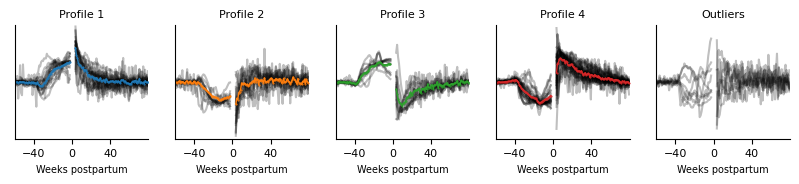

In [18]:
cluster_centers = kmeans.cluster_centers_
X               = zdf.to_numpy().T
distances       = np.linalg.norm(X[:, np.newaxis] - cluster_centers, axis=2)
outliers        = np.where(np.all(distances > np.percentile(distances.min(axis=1),90), axis=1))
clusters[outliers] = 4
print(tests[outliers])

plt.figure(figsize=(10,1.5))
for i in range(n_clusters+1):
    ax = plt.subplot(1,5,i+1)

    zdf.T.loc[clusters==i].T.loc[:0].plot(legend=False,ax=ax,c='k',alpha=0.25)
    zdf.T.loc[clusters==i].T.loc[0:].plot(legend=False,ax=ax,c='k',alpha=0.25)

    if i < 4:
        centroids[i].loc[:0].plot(c=def_color[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
        centroids[i].loc[0:].plot(c=def_color[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)

    ax.set_xlabel('Weeks postpartum',fontsize=7)
    ax.set_xlim([-60,80])
    ax.set_yticks([])
    ax.set_ylim([-6,6])
    ax.set_xticks(np.arange(-40,80,40),fontsize=7)
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    remove_top_right_frame([ax])

ax.set_title('Outliers')    
plt.subplots_adjust(wspace=0.2)
plt.show()

IFFL model for the clusters:

In [19]:
ax,bx,ay,by,t = symbols('a_x,b_x,a_y,b_y,t',positive=True)

x       = Function('x')(t)
y       = Function('y')(t)
u       = Function('u')(t)
dx      = u*bx   - ax*x
dy      = u*by/x - ay*y
deqx    = Eq(Derivative(x),dx)
deqy    = Eq(Derivative(y),dy)
Matrix([deqx,deqy])

⎡ d                             ⎤
⎢ ──(x(t)) = -aₓ⋅x(t) + bₓ⋅u(t) ⎥
⎢ dt                            ⎥
⎢                               ⎥
⎢d                      b_y⋅u(t)⎥
⎢──(y(t)) = -a_y⋅y(t) + ────────⎥
⎣dt                       x(t)  ⎦

We solve the model assuming $y$ dynamics are much faster than $x$. 

We solve the quasi steady state of $y$

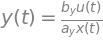

In [20]:
yqst = solve(dy,y)[0]
Eq(y,yqst)

The steady state of the model (when $u(t)$ is constant) is:

In [21]:
xst = solve(dx,x)[0]
Eq(x,xst),Eq(y,yqst.subs(x,xst))

During pregnancy, there is a load on $x$ and $y$, modeled by increasing production rate

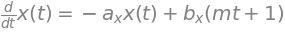

In [22]:
m = symbols('m',positive=True)
load = (1+m*t)
deqx.subs(u,load)

The time-dependend solution for $x(t)$ is:

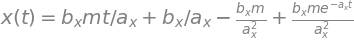

In [23]:
x_pregnancy = dsolve(deqx.subs(u,load),ics={x.subs(t,0):xst.subs(u,1)}).args[1]
Eq(x,x_pregnancy)

And thus for $y$ (assuming quasi steady state)

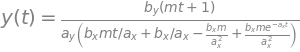

In [24]:
y_pregnancy = yqst.subs(u,load).subs(x,x_pregnancy)
Eq(y,y_pregnancy)

Note that for large $t$, $x$ grows in proportion to the load:

In [25]:
Eq(x,x_pregnancy.series(x=t,x0=oo,n=0).removeO())

And $y$ is compenstated - it doesn't grow indefintly, but rather reaches a steady state

In [26]:
Eq(y,yqst.subs(u,load).subs(x,x_pregnancy.series(x=t,x0=oo,n=0).removeO()).limit(t,oo))

Following 38 weeks of gestation: the values of $x$ and $y$ at delivery ($x_d, y_d$)

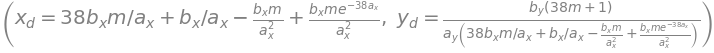

In [27]:
x_d = symbols('x_d')
y_d = symbols('y_d')
Eq(x_d,x_pregnancy.subs(t,38)),Eq(y_d,y_pregnancy.subs(t,38))

Postpartum, $x$ decay to its original steady state:

In [28]:
x_postpartum = dsolve(deqx.subs(u,1),ics={x.subs(t,0):x_d}).args[1]
x_postpartum_full = x_postpartum.subs(x_d,x_pregnancy.subs(t,38))

Eq(x,x_postpartum)

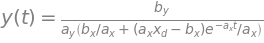

In [29]:
y_postpartum =yqst.subs(u,1).subs(x,x_postpartum)
y_postpartum_full = y_postpartum.subs(x_d,y_pregnancy.subs(t,38))
Eq(y,y_postpartum)

In [30]:
pregnancy_func    = lambdify([t,ax,bx,ay,by,m],[x_pregnancy,y_pregnancy,load])
postpartum_func   = lambdify([t,ax,bx,ay,by,m],[x_postpartum_full,y_postpartum_full,1])
pregnancy_period  = np.arange(-22,38,1); pregnancy_period[pregnancy_period<0] = 0
postpartum_period = np.arange(0,80,1)

def IFFL_analytic_sol(pars):
    nx_preg,ny_preg,nload_preg = pregnancy_func(pregnancy_period,*pars)
    nx_pp,ny_pp,nload_pp       = postpartum_func(postpartum_period,*pars)
    numeric_x                  = np.append(nx_preg,nx_pp)
    numeric_y                  = np.append(ny_preg,ny_pp)
    numeric_load               = np.append(nload_preg,nload_pp)
    return numeric_x, numeric_y,numeric_load

pars  = [0.05,0.05,1,1,0.01]
res   = pd.DataFrame(IFFL_analytic_sol(pars),columns=np.arange(-60,80),index=['x','y','load']).T.fillna(1)

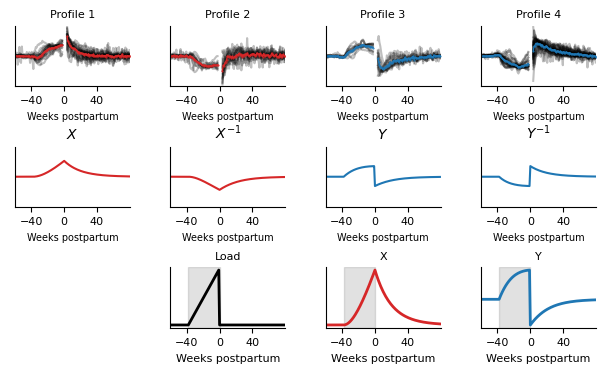

In [31]:
plt.figure(figsize=(7.5,4))
for i in range(n_clusters):
    ax = plt.subplot(3,4,i+1)

    zdf.T.loc[clusters==i].T.loc[:0].plot(legend=False,ax=ax,c='k',alpha=0.25)
    zdf.T.loc[clusters==i].T.loc[0:].plot(legend=False,ax=ax,c='k',alpha=0.25)

    zdf.T.loc[clusters==i].T.mean(axis=1).loc[:0].plot(c=cluster_colors[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
    zdf.T.loc[clusters==i].T.mean(axis=1).loc[0:].plot(c=cluster_colors[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
    ax.set_xlabel('Weeks postpartum',fontsize=7)
    ax.set_xlim([-60,80])
    ax.set_yticks([])
    ax.set_ylim([-6,6])
    ax.set_xticks(np.arange(-40,80,40),fontsize=7)
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    remove_top_right_frame([ax])
    
ax1,ax2,ax3,ax4 = plt.subplot(345),plt.subplot(346),plt.subplot(347),plt.subplot(348)
res['x']           .plot(ax=ax1,c=cluster_colors[0])              
(1/res['x'])       .plot(ax=ax2,c=cluster_colors[1])          
res['y']           .plot(ax=ax3,c=cluster_colors[2])              
(1/res['y'])       .plot(ax=ax4,c=cluster_colors[3])         

remove_top_right_frame([ax1,ax2,ax3,ax4])
[ax.set_yticks([]) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xlabel('Weeks postpartum',fontsize=7) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xlim([-60,80]) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xticks(np.arange(-40,80,40),fontsize=7) for ax in [ax1,ax2,ax3,ax4]]

ax1.set_ylim([1-0.4,1+0.4])
ax2.set_ylim([1-0.4,1+0.4])
ax3.set_ylim([1-0.4,1+0.4])
ax4.set_ylim([1-0.4,1+0.4])

ax1.set_title('$X$',fontsize=10)
ax2.set_title('$X^{-1}$',fontsize=10)
ax3.set_title('$Y$',fontsize=10)
ax4.set_title('$Y^{-1}$',fontsize=10)

ax1,ax2,ax3 = plt.subplot(3,4,10),plt.subplot(3,4,11),plt.subplot(3,4,12)
res.load.plot(ax=ax1,c='k',lw=2)
res.x.plot(ax=ax2,c=def_color[3],lw=2)
res.y.plot(ax=ax3,c=def_color[0],lw=2)

for ax in [ax1,ax2,ax3]:
    ax.set_xlim([-60,80])
    ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20)
    ax.set_yticks([])
    ax.set_xticks([])
    remove_top_right_frame([ax])

ax1.set_title('Load')
ax2.set_title('X')
ax3.set_title('Y')
[ax.set_xticks(np.arange(-40,80,40)) for ax in [ax1,ax2,ax3]]
[ax.set_xlabel('Weeks postpartum') for ax in [ax1,ax2,ax3]]

plt.subplots_adjust(hspace=1,wspace=0.35)
plt.savefig('M_2.pdf',dpi=300,bbox_inches = 'tight',pad_inches=0.1); plt.show()
plt.show()

# Postpartum dyanmics

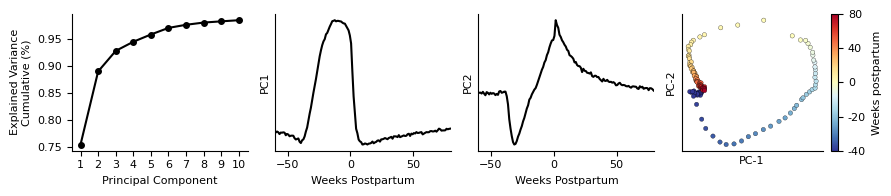

In [32]:
def scale_weeks(weeks): ## define coloarmap
    temp           = weeks.copy()
    temp[temp < 0] = temp[temp < 0]/38
    temp[temp > 0] = temp[temp > 0]/80
    return temp

minima = -1
maxima = 1
norm   = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdYlBu_r)


tdf            = pd.DataFrame([get_test_data(test)['quantile']['value'] for test in tests],index=tests).fillna(method ='backfill').T
pca            = PCA(); pca.fit(tdf)
explained_var  = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
pcomps         = pd.DataFrame(data = pca.fit_transform(tdf.to_numpy()),index=tdf.index)
pcolors        = scale_weeks(tdf.index.to_numpy())


plt.figure(figsize=(9,2))
ax  = plt.subplot(141)
ax.plot(range(1, len(explained_var[:10]) + 1), cumulative_var[:10],marker='o',c='k',markersize=4)

ax.set_xticks(range(1, len(explained_var) + 1))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance\nCumulative (%)')
ax.set_xlim([0.5,10.5])
remove_top_right_frame([ax])


## plot
ax   = plt.subplot(142)
pcomps[0].plot(ax=ax,ylabel='PC1',c='k')
remove_top_right_frame([ax])
ax.set_xlim([-60,80])
ax.set_xlabel('Weeks Postpartum')
ax.set_yticks([])

ax   = plt.subplot(143)
pcomps[1].plot(ax=ax,ylabel='PC2',c='k')
remove_top_right_frame([ax])
ax.set_xlim([-60,80])
ax.set_xlabel('Weeks Postpartum')
ax.set_yticks([])

ax   = plt.subplot(144)
scat = ax.scatter(pcomps[0],pcomps[1],c=mapper.to_rgba(pcolors),s=10,edgecolor='k',lw=0.2)
ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
remove_top_right_frame([ax])
cbar = plt.colorbar(mapper,ax=ax,label="Weeks postpartum")
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.set_ticklabels([-40,-20,0,40,80])
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

In [33]:
explained_var[:2]

array([0.75419581, 0.13589057])

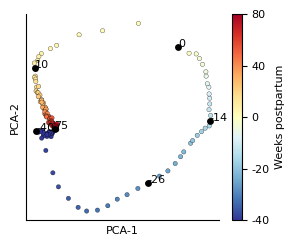

In [34]:
def annotate_point(week,projections,ax,label=[]):
    if not label:
        label= str(week)
    x_,y_ = projections.loc[week + 0.5].to_numpy()
    ax.text(x_,y_,label,alpha=0.99)
    ax.scatter(x_,y_,s=15,c='k')


plt.figure(figsize=(3,2.5))
ax   = plt.subplot(111)
scat = ax.scatter(pcomps[0],pcomps[1],c=mapper.to_rgba(pcolors),s=10,edgecolor='k',lw=0.2)
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')
remove_top_right_frame([ax])
cbar = plt.colorbar(mapper,ax=ax,label="Weeks postpartum")
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.set_ticklabels([-40,-20,0,40,80])
[annotate_point(t,pcomps[[0,1]],ax) for t in [-40,-26,-14,0,10,75]]
plt.xticks([])
plt.yticks([])

plt.tight_layout() 
plt.savefig('M_3A.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300);     
plt.show()

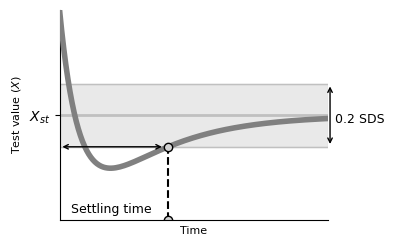

In [35]:
plt.figure(figsize=(4,2.5))
ax = plt.subplot(111)
x  = np.arange(0,13,0.1)
A  = -1.5
a  = 0.3
B  = 2.5
b  = 1
y1 = A*np.e**(-a*x)
y2 = B*np.e**(-b*x)
y  = y1 +  y2

eband = 0.3
ax.plot(x,y,c='gray',lw=4,zorder=5)

ax.set_xlim([0,np.max(x)])   ; ax.set_xticks([])       ; ax.set_xlabel('Time')
ax.set_ylim([-1,1]); 

ax.set_yticks([0]); ax.set_ylabel('Test value ($X$)');
ax.set_yticklabels(['$X_{st}$'],fontsize=10)

stime  = x[np.argmin(np.abs((np.abs(y) - eband)))]
ax.axhline(0,zorder=-4,c='silver',lw=2)
ax.axhline(eband,zorder=-10,c='silver',lw=1)
ax.axhline(-eband,zorder=-10,c='silver',lw=1)
ax.axhspan(-eband,eband,alpha=0.35,zorder=-10,color='silver')

ax.scatter([stime],[-1],c='lightgray',zorder=0,marker='o',edgecolor='k')
ax.scatter([stime],[-eband],c='lightgray',zorder=10,marker='o',edgecolor='k')

ax.plot([stime,stime],[-1,-eband],c='k',ls='--',zorder=-1)
ax.annotate("", xy=(0, -eband), xytext=(stime-0.15, -eband), arrowprops=dict(arrowstyle="<->",color='k'),zorder=10)
ax.annotate("Settling time", xy=(2.5, -0.925),zorder=10,c='k',ha='center',fontsize=9)

ax.annotate("", xy=(13, -eband), xytext=(13, eband), arrowprops=dict(arrowstyle="<->",color='k'),zorder=10, annotation_clip=False)

ax.annotate("0.2 SDS", xy=(13.25, -0.075),zorder=10,c='k',ha='left',fontsize=9, xycoords='data', annotation_clip=False)

rtimeA = np.log(2)/a
rtimeB = np.log(2)/b

remove_top_right_frame([ax])
plt.tight_layout()
plt.savefig('M_3B.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()

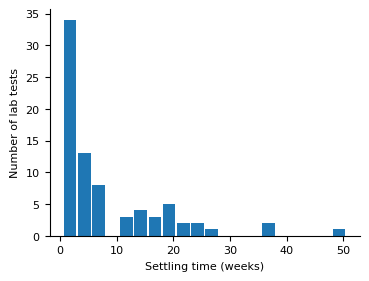

In [36]:
from scipy.ndimage import gaussian_filter

sds_threshold = 0.2
sett_time = []
for i,test in enumerate(tests):

    x,mu,err,n = get_stats_from_dataset(test,'postpartum_SDS',merge_timepoints=False)
    y          = mu.fillna(method='backfill')
    y          = pd.DataFrame(gaussian_filter(y, sigma=1, mode='nearest'),index=y.index)
    
    if np.mean(err) > sds_threshold:
        sett = np.nan
    else:

        sett0 = y.dropna().index[0]
        temp  = (np.abs(y) > sds_threshold).values
        if np.sum(temp) == 0:
            sett  = sett0
        else:
            wsett = np.argwhere(np.array([np.sum(temp[i:])/len(temp[i:]) for i in range(len(temp))])< 0.1)
            if len(wsett)>0:
                try:
                    sett = y.index[wsett[0][0]]
                    sett = y.loc[sett+1:].index[np.argwhere((np.abs(y).loc[sett+1:]<sds_threshold).values)[0][0]]
                except:
                    sett = np.nan
    sett_time.append(sett)
    
plt.figure(figsize=(4,3))
ax1              = plt.subplot(111)
N, bins, patches = ax1.hist(sett_time,bins=20, zorder=2, rwidth=0.9)
ax1.set_xlabel('Settling time (weeks)')
ax1.set_ylabel('Number of lab tests')
remove_top_right_frame([ax1])
plt.show()

In [37]:
group_color ={'Liver'          : def_color[5],
              'Musculoskeletal': def_color[7],
              'Immune'         : def_color[0],
              'RBCs'           : def_color[3],
              'Metabolism'     : def_color[1],
              'Coagulation'    : def_color[4],
              'Endocrine'      : def_color[2],
              'Renal'          : def_color[6]}  

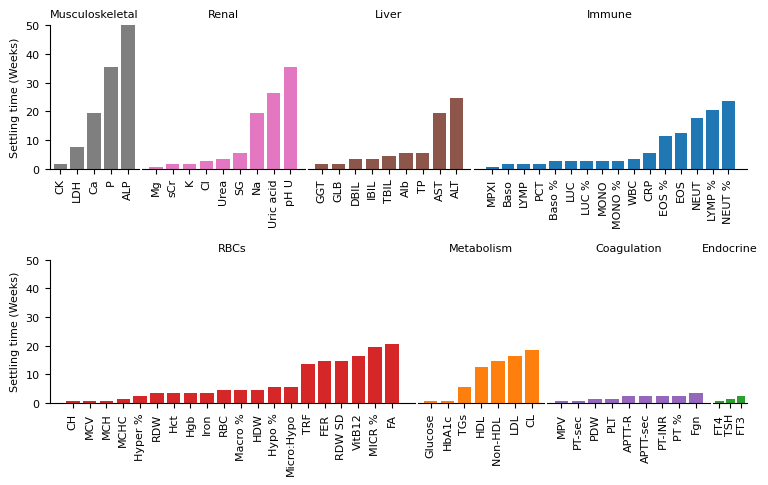

In [38]:
df_sett_time          = pd.DataFrame(sett_time,index=tests,columns=['settling time'])
df_sett_time['Group'] = metadata['Group'].loc[tests]
df_sett_time['test']  = [metadata.loc[test]['Short name'] for test in tests]

def bar_plot_ax(ax,tdf,c):
    ax.bar(range(len(tdf)),tdf['settling time'],color=c)
    ax.set_xticks(range(len(tdf)))   
    ax.set_xticklabels(tdf['test'],rotation=90)   
    ax.set_title(tdf['Group'].iloc[0])
    ax.set_ylim([0,50])
    remove_top_right_frame([ax]) 
        
groups_ordered = ['Musculoskeletal','Renal','Liver','Immune','RBCs','Metabolism','Coagulation','Endocrine']
fig = plt.figure(layout="constrained",figsize=(9,5))
gs  = GridSpec(5, 38, figure=fig)

for i,group in enumerate(groups_ordered):
    if i < 4:
        k = 0
    else:
        k = 3
    
    if np.mod(i,4) == 0:
        L0 = 0
        L1 = L0+len(df_sett_time.loc[df_sett_time.Group ==group])
        ax = fig.add_subplot(gs[k:k+2, L0:L1])   
        ax.set_ylabel('Settling time (Weeks)')
    else:
        L1 = L0+len(df_sett_time.loc[df_sett_time.Group ==group])
        ax = fig.add_subplot(gs[k:k+2, L0:L1])   
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)

    bar_plot_ax(ax,df_sett_time.loc[df_sett_time.Group ==group].sort_values(by='settling time'),c=group_color[group])
    L0 = L1
    
    
plt.savefig('M_3C.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()

# Preconception dyanmics

In [39]:
def lin_reg(xdat,a,b):
    return a + b*xdat

summery = []
for i,test in enumerate(tests):
    tdf   = get_test_data(test)['quantile']*100
    ydat  = tdf.loc[:-38]['value'].values
    yerr  = tdf.loc[:-38]['error'].values
    xdat  = tdf.loc[:-38]['value'].index
    n     = tdf.loc[:-38]['n'].values
    popt,pcov  = curve_fit(lin_reg,xdat,ydat,sigma=yerr)
    perr       = np.sqrt(np.diag(pcov))
    zscore     = popt[1]/perr[1]
    summery.append([zscore,*popt,*perr])

reg_res                    = pd.DataFrame(summery,index=tests,columns=['Zscore','intercept','coeff','intercept_sd','coeff_sd'])
reg_res['abs_zscore']      = np.abs(reg_res['Zscore'])
reg_res['pvalue']          = stats.norm.sf(reg_res['abs_zscore']).flat[:]
reg_res['pvalue_adjusted'] = fdrcorrection(reg_res['pvalue'])[1]
reg_res['FDR']             = reg_res['pvalue_adjusted'] < 0.05
reg_res['Name']            = [metadata.loc[test]['Nice name'] for test in reg_res.index]
reg_res['significant']     = (np.abs(reg_res['coeff']) > 0.1) & reg_res['FDR']

In [40]:
df_precon          = pd.DataFrame(reg_res[['coeff','coeff_sd','significant']],index=tests)
df_precon['Group'] = metadata['Group'].loc[tests]
df_precon['test']  = [metadata.loc[test]['Short name'] for test in tests]
df_precon['coeff_ci']    = df_precon['coeff_sd']*2

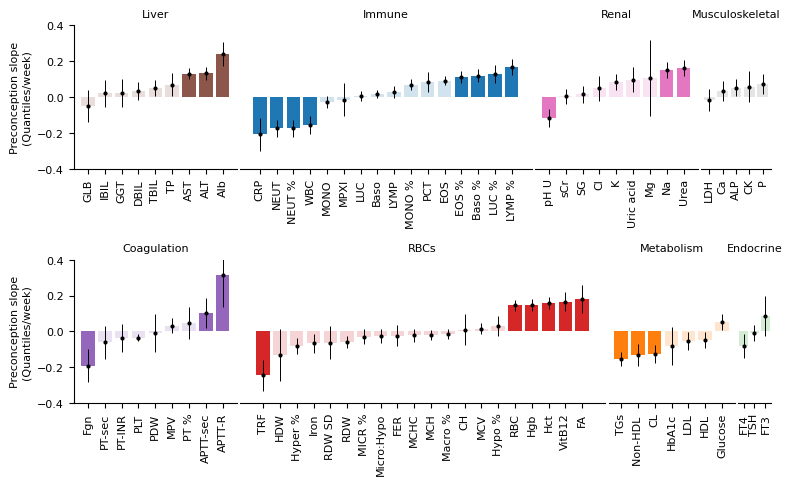

In [41]:
def bar_plot_ax(ax,tdf,c):
    bars = ax.bar(range(len(tdf)),tdf['coeff'],color=c)
    for bar, significant in zip(bars, tdf['significant']):
        if not significant:  # If 'significant' is False
            bar.set_alpha(0.2)  # Set alpha to 0.2
    
    ax.errorbar(range(len(tdf)),tdf['coeff'],tdf['coeff_ci'],color='k',fmt='o',markersize=2,alpha=1,linewidth=0.7)
    ax.set_xticks(range(len(tdf)))   
    ax.set_xticklabels(tdf['test'],rotation=90)   
    ax.set_title(tdf['Group'].iloc[0])
    ax.set_ylim([-0.4,0.4])
    remove_top_right_frame([ax])  

groups_ordered = ['Liver','Immune','Renal','Musculoskeletal','Coagulation','RBCs','Metabolism','Endocrine']

fig = plt.figure(layout="constrained",figsize=(9,5))
gs  = GridSpec(5, 38, figure=fig)
 
for i,group in enumerate(groups_ordered):
    if i < 4:
        k = 0
    else:
        k = 3
    
    if np.mod(i,4) == 0:
        L0 = 0
        L1 = L0+len(df_precon.loc[df_precon.Group ==group])
        ax = fig.add_subplot(gs[k:k+2, L0:L1])   
        ax.set_ylabel('Preconception slope\n(Quantiles/week)')
    else:
        L1 = L0+len(df_precon.loc[df_precon.Group ==group])
        ax = fig.add_subplot(gs[k:k+2, L0:L1])   
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)

    bar_plot_ax(ax,df_precon.loc[df_precon.Group ==group].sort_values(by='coeff'),c=group_color[group])
    L0 = L1
        
plt.savefig('M_5B.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()

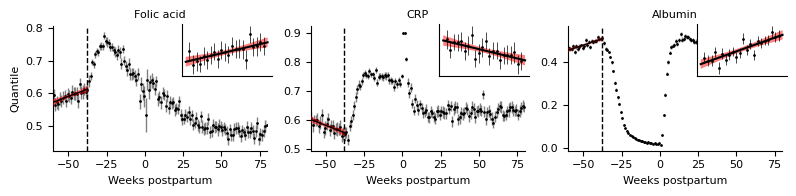

In [42]:
def plot_preconception(test,axi):

    ax    = axi.inset_axes([0.6, 0.6, 0.42, 0.42])
    tdf   = get_test_data(test)['quantile']
    ydat  = tdf.loc[:-38]['value'].values
    yerr  = tdf.loc[:-38]['error'].values
    xdat  = tdf.loc[:-38]['value'].index
    n     = tdf.loc[:-38]['n'].values

    x,v,e,n = get_stats_from_dataset(test,'quantile',merge_timepoints=False)
    axi.errorbar(x,v,e,c='k',lw=1,fmt='o',markersize=1,zorder=-3,ecolor='gray')   

    popt,pcov  = curve_fit(lin_reg,xdat,ydat,sigma=yerr)
    perr       = np.sqrt(np.diag(pcov))
    zscore     = popt[1]/perr[1]
    ypred = lin_reg(xdat,*popt)

    n     = len(ydat)
    m     = len(popt)
    dof   = n - m
    alpha = 0.05
    tails = 2
    t_critical = stats.t.ppf(1 - (alpha / tails), dof)

    y_bar = np.mean(ypred)
    R2    = np.sum((ypred - y_bar)**2) / np.sum((ydat - y_bar)**2)

    resid    = ydat - ypred
    chi2     = sum((resid / ypred)**2)
    chi2_red = chi2 / dof
    std_err  = np.sqrt(sum(resid**2) / dof)

    ax.errorbar(xdat, ydat,yerr,fmt='o',c='k',markersize=1,lw=0.5)
    xlim     = ax.get_xlim()
    ylim     = ax.get_ylim()
    x_fitted = np.linspace(xlim[0], xlim[1], 100)
    y_fitted = lin_reg(x_fitted,*popt)
    ci       = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(xdat))**2 / np.sum((xdat - np.mean(xdat))**2))

    ax.plot(np.array(xlim), popt[0] + popt[1] * np.array(xlim),c='k')
    axi.plot(np.array(xlim), popt[0] + popt[1] * np.array(xlim),lw=1,c='k', zorder=7)

    ax. fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor='r',alpha=0.5, zorder=1)  
    axi.fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor='r',alpha=0.5, zorder=6)   

    axi.set_xlim([-60,80])
    axi.set_xlabel('Weeks postpartum')
    ax.set_xticks([])
    ax.set_yticks([])
    axi.axvline(x=-38,c='k',ls='--',lw=1)
    axi.set_title('')
    axi.set_title(metadata.loc[test]['Nice name'])
    axi.annotate('Conception',(-36,16.5),fontsize=8)
    remove_top_right_frame([axi,ax])
    
    
plt.figure(figsize=(8,2))
ax1,ax2,ax3   = plt.subplot(131),plt.subplot(132),plt.subplot(133)     
plot_preconception('FOLIC_ACID',ax1)
plot_preconception('C_REACTIVE_PROTEIN_CRP',ax2)
plot_preconception('ALBUMIN',ax3)
ax1.set_ylabel('Quantile')
plt.tight_layout();
plt.savefig('M_5ABC.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()

# System by System

In [43]:
def plot_tests_one_axe(ax,tests,title,return_color=False,set_color=None):
    qstd   = pd.DataFrame([data[test]['quantile']['value'].std() for test in tests],index = tests)
    tests_ = qstd.sort_values(by =0,ascending=False).index
    norm   = matplotlib.colors.Normalize(vmin=0, vmax=len(tests_)-1, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.turbo)
    
    for j,test in enumerate(tests_):
        x,v,e,n = get_stats_from_dataset(test,'quantile')
        offset  = get_stats_from_dataset(test,'quantile')[1].iloc[:5].mean()
        v       = v - offset
        
        if set_color is None:  
            color = mapper.to_rgba(j)
        else:
            color = set_color[test]
            
        ax.plot(x,v,c=color,lw=0.5,zorder=-3,alpha=0.8-0.4*((len(tests_)-j)/len(tests_)))
        ax.fill_between(x,v+e,v-e,color=color,lw=1,zorder=-3,alpha=0.6-0.45*((len(tests_)-j)/len(tests_)))
        max_min = np.argmax([np.abs(0.5 - v.max()),np.abs(0.5-v.min())])
        xl      = np.array([v.idxmax(),v.idxmin()])[max_min]
        yl      = np.array([v.max(),v.min()])[max_min]
        txt     = ax.text(xl,yl,metadata.loc[test]['Nice name'],ha='center',fontsize=8,color=color,alpha=0.8-0.4*((len(tests_)-j)/len(tests_)))
    
    ax.set_yticks(np.arange(-0.5,0.75,0.25)); ax.set_ylabel('Quantile Change'); ax.set_ylim([-0.5,0.5])
    ax.set_xticks(np.arange(-60,100,20)) ; ax.set_xlabel('Weeks postpartum'); ax.set_xlim([-60,80])
    ax.axvspan(-38,0,color='dimgray',alpha=0.1,zorder=-20)
    ax.set_facecolor('w')
    remove_top_right_frame([ax])
    ax.text(-54,0.425,title,fontsize=10,color='k')
    
    if return_color:
        colormapper = [(test,mapper.to_rgba(j))for j,test in enumerate(tests_)]
        return colormapper

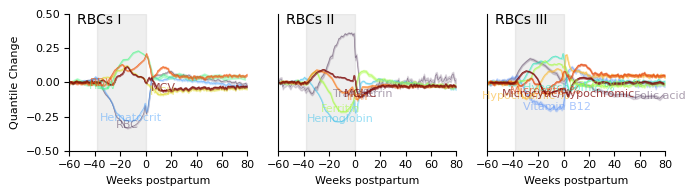

In [44]:
#### RBCs
plt.figure(figsize=(7,2))
ax1,ax2,ax3  = plt.subplot(1,3,1),plt.subplot(1,3,2),plt.subplot(1,3,3)
plot_tests_one_axe(ax1,['RBC', 'HCT','MCV','MCH','RDW','HDW'],'RBCs I')
plot_tests_one_axe(ax2,['FERRITIN','IRON','HGB','TRANSFERRIN','MCHC'],'RBCs II')
plot_tests_one_axe(ax3,['MICR_perc','MICROperc_HYPOperc','MACROperc','HYPERperc',
                        'HYPO_perc','VITAMIN_B12','FOLIC_ACID'],'RBCs III')
for ax in [ax2,ax3]:
    ax.set_ylabel('') 
    ax.set_yticklabels([])
    ax.set_yticks([]) 
plt.tight_layout(); plt.savefig('M_6_RBCs_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()


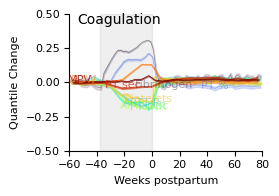

In [45]:
#### Coagulation
plt.figure(figsize=(7,2))
ax1   = plt.subplot(1,3,1)
plot_tests_one_axe(ax1,['FIBRINOGEN', 'APTT_R','APTT_sec','PT_INR',
                        'PT_SEC','PT_perc','PDW','MPV','PLT'],'Coagulation')
plt.tight_layout(); plt.savefig('M_6_Coagulation_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

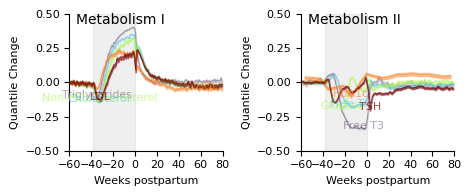

In [46]:
#### Metabolism
plt.figure(figsize=(7,2))
ax1,ax2  = plt.subplot(1,3,1),plt.subplot(1,3,2)
plot_tests_one_axe(ax1,['TRIGLYCERIDES', 'CHOLESTEROL','CHOLESTEROL_HDL',
                        'CHOLESTEROL_LDL','NON_HDL_CHOLESTEROL'],'Metabolism I')
plot_tests_one_axe(ax2,['GLUCOSE_BLOOD','HEMOGLOBIN_A1C_CALCULATED','T4_FREE','T3_FREE','TSH_THYROID_STIMULATING_HORMONE'],'Metabolism II ')

plt.tight_layout(); plt.savefig('M_6_Metabolism_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

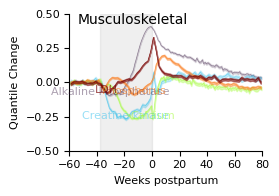

In [47]:
#### Musculoskeletal
plt.figure(figsize=(7,2))
ax1 = plt.subplot(1,3,1)
plot_tests_one_axe(ax1,['PHOSPHATASE_ALKALINE', 'LACTIC_DEHYDROGENASE_LDH__BLOOD','PHOSPHORUS_BLOOD',
                        'CALCIUM_BLOOD','CK_CREAT'],'Musculoskeletal')
plt.tight_layout(); plt.savefig('M_6_Musculoskeletal_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

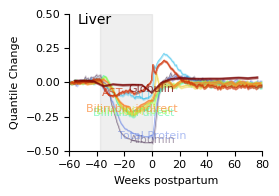

In [48]:
#### Liver
plt.figure(figsize=(7,2))
ax1  = plt.subplot(1,3,1)
plot_tests_one_axe(ax1,['PROTEIN_TOTAL_BLOOD', 'ALBUMIN','GLOBULIN','ALT_Alanine_aminotransferase_GPT',
                        'AST_Aspartate_aminotransferase_GOT','GAMMA_GLUTAMYL_TRANSPEPTIDASE',
                       'BILIRUBIN_DIRECT','BILIRUBIN_INDIRECT','BILIRUBIN_TOTAL'],'Liver')
plt.tight_layout(); plt.savefig('M_6_Liver_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

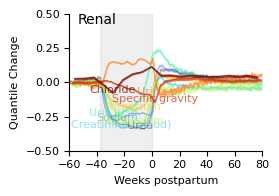

In [49]:
#### Kidney 
plt.figure(figsize=(7,2))
ax1  = plt.subplot(1,3,1)
plot_tests_one_axe(ax1,['CREATININE_BLOOD', 'UREA_BLOOD','URIC_ACID_BLOOD',
                        'Na','K','Cl','MAGNESIUM_BLOOD','PH_u','SPECIFIC_GRAVITY'],'Renal')
plt.tight_layout(); plt.savefig('M_6_Kidney_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

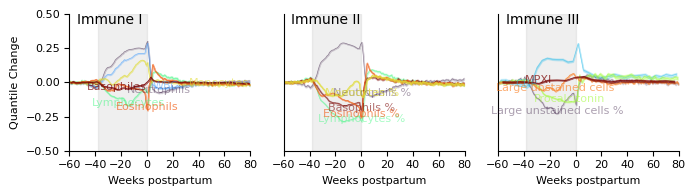

In [50]:
#### Immune
plt.figure(figsize=(7,2))
ax1,ax2,ax3  = plt.subplot(1,3,1),plt.subplot(1,3,2),plt.subplot(1,3,3)

col_d = plot_tests_one_axe(ax1,['NEUT'    ,'EOS'     ,'MONO'   ,'LYMP','BASOPHILES_abs','WBC'],'Immune I',return_color=True)
set_col_d = {'NEUTperc':col_d[0][1],
             'EOS_perc':col_d[4][1],
             'MONperc':col_d[3][1],
             'LYMperc':col_d[2][1],
             'BASO_perc':col_d[5][1]}

plot_tests_one_axe(ax2,['NEUTperc','EOS_perc','MONperc','LYMperc','BASO_perc'],'Immune II',set_color=set_col_d)
plot_tests_one_axe(ax3,['C_REACTIVE_PROTEIN_CRP','LUC','LUCperc','PCT','MPXI'],'Immune III')
for ax in [ax2,ax3]:
    ax.set_ylabel('') 
    ax.set_yticklabels([])
    ax.set_yticks([])   
plt.tight_layout(); plt.savefig('M_6_Immune_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

# Thyroid model

### Yael's HPT model 
from "Dynamics of thyroid diseases and thyroid-axis gland masses" MSB (2022)

$x_1,x_2,x_3$ are $TRH, TSH$ and ($FT4$ or $FT3$) blood concentration

$P,T$ are the functional masses of the pituitary and thyroid hormone secreting cells

In [51]:
x1,x2,x3,m1,m2,a1,a2,a3,b1,b2,b3,bp,bt,ap,at = symbols('x_1,x_2,x_3,m_1,m_2,a_1,a_2,a_3,b_1,b_2,b_3,b_P,b_T,a_P,a_T',positive=True)
t,p      = symbols('t,p' ,positive=True)
X1       = Function('x_1',positive=True)(t)
X2       = Function('x_2',positive=True)(t)
X3       = Function('x_3',positive=True)(t)
P        = Function('P',positive=True)(t)
T        = Function('T',positive=True)(t)

dx1      = b1/X3       - a1*X1  
dx2      = b2*P*X1/X3 - a2*X2       
dx3      = b3*T*X2    - a3*X3    
dP       = P*(bp/X3   - ap)
dT       = T*(bt*X2   - at)

deqs     = Matrix([Eq(X1.diff(t), dx1),
                   Eq(X2.diff(t), dx2),
                   Eq(X3.diff(t), dx3),
                   Eq(P.diff(t), dP),
                   Eq(T.diff(t), dT)])

display(deqs)

⎡    d                         b₁     ⎤
⎢    ──(x₁(t)) = -a₁⋅x₁(t) + ─────    ⎥
⎢    dt                      x₃(t)    ⎥
⎢                                     ⎥
⎢d                       b₂⋅P(t)⋅x₁(t)⎥
⎢──(x₂(t)) = -a₂⋅x₂(t) + ─────────────⎥
⎢dt                          x₃(t)    ⎥
⎢                                     ⎥
⎢d                                    ⎥
⎢──(x₃(t)) = -a₃⋅x₃(t) + b₃⋅T(t)⋅x₂(t)⎥
⎢dt                                   ⎥
⎢                                     ⎥
⎢   d          ⎛        b_P ⎞         ⎥
⎢   ──(P(t)) = ⎜-a_P + ─────⎟⋅P(t)    ⎥
⎢   dt         ⎝       x₃(t)⎠         ⎥
⎢                                     ⎥
⎢ d                                   ⎥
⎢ ──(T(t)) = (-a_T + b_T⋅x₂(t))⋅T(t)  ⎥
⎣ dt                                  ⎦

The steady state of the model:

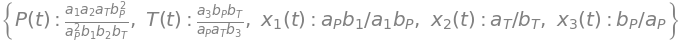

In [52]:
stst     = to_dict([X1,X2,X3,P,T],solve(Matrix([dx1,dx2,dx3,dP,dT]),[X1,X2,X3,P,T])[0])
display(stst)

Rescaling of the models variable by some of the parameters such that steady state equals to 1 (see methods)

In [53]:
simp     = {b1:a1,b2:a2,b3:a3,bp:ap,bt:at}
display(to_dict([X1,X2,X3,P,T],Matrix(solve(Matrix([dx1,dx2,dx3,dP,dT]),[X1,X2,X3,P,T])[0]).subs(simp)))

We note seperation of timescales, and solve the hormones quasi steady state - it is a function of the gland masses

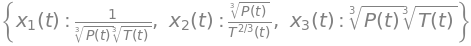

In [54]:
qst      = to_dict([X1,X2,X3],solve(Matrix([dx1,dx2,dx3]).subs(simp),[X1,X2,X3])[0])
display(qst)

We substitue the quasi steady state into the gland eqautions to find a system of 2 differeatnial equations:

In [55]:
mdeqs    = Matrix([Eq(P.diff(t),dP),
                   Eq(T.diff(t),dT)]).subs(qst).subs(simp)
display(mdeqs)

⎡d          ⎛              a_P       ⎞     ⎤
⎢──(P(t)) = ⎜-a_P + ─────────────────⎟⋅P(t)⎥
⎢dt         ⎜       3 ______ 3 ______⎟     ⎥
⎢           ⎝       ╲╱ P(t) ⋅╲╱ T(t) ⎠     ⎥
⎢                                          ⎥
⎢              ⎛    3 ______      ⎞        ⎥
⎢   d          ⎜a_T⋅╲╱ P(t)       ⎟        ⎥
⎢   ──(T(t)) = ⎜──────────── - a_T⎟⋅T(t)   ⎥
⎢   dt         ⎜   2/3            ⎟        ⎥
⎣              ⎝  T   (t)         ⎠        ⎦

We subtract 1 in order to model the relative change from the steady state

In [56]:
Y2       = Function('y_2')(t)
Y3       = Function('y_3')(t)

ysols = Matrix([Eq(Y2,qst[X2]-1),
                Eq(Y3,qst[X3]-1)])
display(ysols)

⎡            3 ______         ⎤
⎢            ╲╱ P(t)          ⎥
⎢    y₂(t) = ──────── - 1     ⎥
⎢             2/3             ⎥
⎢            T   (t)          ⎥
⎢                             ⎥
⎢        3 ______ 3 ______    ⎥
⎣y₃(t) = ╲╱ P(t) ⋅╲╱ T(t)  - 1⎦

In [57]:
import matplotlib.ticker as ticker
def format_ticks(x, pos):
    return f'{x*100:.0f}'

### First, we consider a model based on FT4 dynamics

We normalize T4 and TSH data to realtive change from postpartum basline

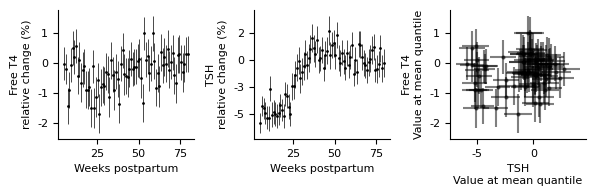

In [58]:
def get_postpartum_relative_change_stats(test,period=[5,80]):
    df       = get_value_at_quantile_stats(test).loc[period[0]:period[1]]
    df['sd'] = df['error']*np.sqrt(df['n'])    
    mu_end   = np.sum(df.loc[70:]['n']*df.loc[70:]['value'])/(np.sum(df.loc[70:]['n']))
    sd_end   = np.sqrt(np.sum(df.loc[70:]['n']*df.loc[70:]['sd']**2)/(np.sum(df.loc[70:]['n'])))    
    v        = df['value']/mu_end - 1
    e        = df['error']/mu_end
    return df.index,v,e,df['n']

xdat,ydat_y2,yerr_y2,n_y2 = get_postpartum_relative_change_stats('TSH_THYROID_STIMULATING_HORMONE',period=[5,80])
xdat,ydat_y3,yerr_y3,n_y3 = get_postpartum_relative_change_stats('T4_FREE',period=[5,80])
xplot                     = np.arange(0,80,1).astype(int)

plt.figure(figsize=(6,2))

ax1,ax2,ax3 = plt.subplot(131),plt.subplot(132),plt.subplot(133)

ax1.errorbar(xdat,ydat_y3,yerr_y3,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax1.set_xlabel('Weeks postpartum',fontsize=8)
ax1.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax2.errorbar(xdat,ydat_y2,yerr_y2,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax2.set_xlabel('Weeks postpartum',fontsize=8)
ax2.set_ylabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2,alpha=0.5)
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name']+'\nValue at mean quantile')
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name']+'\nValue at mean quantile')

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

remove_top_right_frame([ax1,ax2,ax3])
plt.tight_layout();
plt.show()

To fit the model, we simualte differential equations of the glands, with hormones at quasi steady-state

In [59]:
mdeqs_func = lambdify([P,T,ap,at],[mdeqs[0].args[1],mdeqs[1].args[1]])
ys_func    = lambdify([P,T],[ysols[0].args[1],ysols[1].args[1]])

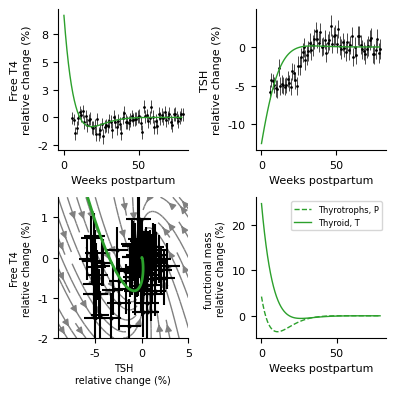

In [60]:
#### Fitting intial conditions, turnover rates from Yael's paper = 1/30 days for both glands
pm_yael_paper =  7*(30)**-1

def sim_mdeqs(y,t):
    P,T = y
    ap=at=pm_yael_paper
    return mdeqs_func(P,T,ap,at)

def obj_func(xdat,P0,T0):
    msols = odeint(sim_mdeqs,[P0,T0],np.arange(0,80))
    ysols = ys_func(msols[xdat.astype(int),0],msols[xdat.astype(int),1])
    return np.array(ysols).flat[:]

ydat              = np.append(ydat_y2.values,ydat_y3.values)
bounds            = ((0.8,0.8), (1.5,1.5))
popts,pcov        = curve_fit(obj_func,xdat,ydat,maxfev = 100000, p0 = [0.97,1.2], bounds=bounds)
ypred             = obj_func(xplot,*popts); y2_pred = ypred[:len(xplot)]; y3_pred = ypred[len(xplot):]

def f_dt(Y,dt):
    y20, y30 = Y
    x20, x30 = y20+1,y30+1
    P0,T0    = np.array((nsolve([qst[X2]-x20,qst[X3]-x30],[P,T],[1,1]))).astype(float).flat[:]
    dP,dT    = mdeqs_func(P0,T0,pm_yael_paper,pm_yael_paper)*dt
    P1,T1  = P0+dP, T0+dT
    x21      = P1**(1/3) * T1**(-2/3)
    x31      = P1**(1/3) * T1**(1/3)
    return x21-x20, x31-x30

n_arrows = 10
y2_lim   = [-0.09, 0.05]
y3_lim   = [-0.02, 0.015]
y2_range = np.linspace(y2_lim[0], y2_lim[1], n_arrows)
y3_range = np.linspace(y3_lim[0], y3_lim[1], n_arrows)
Y2_, Y3_ = np.meshgrid(y2_range, y3_range)
v2, v3   = np.zeros(Y2_.shape), np.zeros(Y3_.shape)

for i in range(n_arrows):
    for j in range(n_arrows):
        yprime  = f_dt([Y2_[i, j], Y3_[i, j]], 1)
        v2[i,j] = yprime[0]
        v3[i,j] = yprime[1]
        
        
plt.figure(figsize=(4,4))
ax1,ax2,ax3,ax4 = plt.subplot(221),plt.subplot(222),plt.subplot(223),plt.subplot(224)

ax1.plot(xplot,y3_pred,c=def_color[2],lw=1)
ax1.errorbar(xdat,ydat_y3,yerr_y3,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax1.set_xlabel('Weeks postpartum',fontsize=8)
ax1.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax2.plot(xplot,y2_pred,c=def_color[2],lw=1); 
ax2.errorbar(xdat,ydat_y2,yerr_y2,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax2.set_xlabel('Weeks postpartum',fontsize=8)
ax2.set_ylabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='gray', linewidth=1)
ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2)
ax3.set_xlim(y2_lim)
ax3.set_ylim(y3_lim)
ax3.plot(y2_pred,y3_pred,lw=2,c=def_color[2],zorder=4)
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=7)
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=7)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

msols = odeint(sim_mdeqs,[popts[0],popts[1]],xplot) ; P_pred = msols[xplot,0]; T_pred =msols[xplot,1]
ax4.plot(xplot,msols[:,0]-1,lw=1,ls='--',c=def_color[2])
ax4.plot(xplot,msols[:,1]-1,lw=1,c=def_color[2])

ax4.set_ylabel('functional mass \nrelative change (%)',fontsize=7)
ax4.set_xlabel('Weeks postpartum',fontsize=8)
ax4.legend(['Thyrotrophs, P','Thyroid, T'],fontsize=6)
remove_top_right_frame([ax1,ax2,ax3,ax4])
plt.tight_layout(); 
# plt.savefig('thyroid_fit_yael_model.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

gland_mass_yael_pred = pd.DataFrame(np.array([y2_pred,y3_pred,P_pred,T_pred]).T,columns=['x2','x3','P','T'],index=xplot)

Linearization of the model provides good approximation of the simulation

In [61]:
lin_deqs = Matrix([Eq(X1.diff(t),dx1.diff(X1).subs(stst)*(X1-1) + dx1.diff(X2).subs(stst)*(X2-1) + dx1.diff(X3).subs(stst)*(X3-1) + dx1.diff(P).subs(stst)*(P-1) + dx1.diff(T).subs(stst)*(T-1)),
                   Eq(X2.diff(t),dx2.diff(X1).subs(stst)*(X1-1) + dx2.diff(X2).subs(stst)*(X2-1) + dx2.diff(X3).subs(stst)*(X3-1) + dx2.diff(P).subs(stst)*(P-1) + dx2.diff(T).subs(stst)*(T-1)),
                   Eq(X3.diff(t),dx3.diff(X1).subs(stst)*(X1-1) + dx3.diff(X2).subs(stst)*(X2-1) + dx3.diff(X3).subs(stst)*(X3-1) + dx3.diff(P).subs(stst)*(P-1) + dx3.diff(T).subs(stst)*(T-1)),
                   Eq(P.diff(t),dP.diff(X1).subs(stst)*(X1-1) + dP.diff(X2).subs(stst)*(X2-1) + dP.diff(X3).subs(stst)*(X3-1) + dP.diff(P).subs(stst)*(P-1) + dP.diff(T).subs(stst)*(T-1)),
                   Eq(T.diff(t),dT.diff(X1).subs(stst)*(X1-1) + dT.diff(X2).subs(stst)*(X2-1) + dT.diff(X3).subs(stst)*(X3-1) + dT.diff(P).subs(stst)*(P-1) + dT.diff(T).subs(stst)*(T-1))]).subs(simp)
                
Y1       = Function('y_1')(t)
Y2       = Function('y_2')(t)
Y3       = Function('y_3')(t)
Z1       = Function('Z_1')(t)
Z2       = Function('Z_2')(t)

lin_subs = {X1:Y1+1,X2:Y2+1,X3:Y3+1,P:Z1+1,T:Z2+1}
lin_deqs = lin_deqs.subs(lin_subs)
display(lin_deqs)

lqst  = solve([lin_deqs[0].args[1],lin_deqs[1].args[1],lin_deqs[2].args[1]],[Y1,Y2,Y3])
display(lqst)

zdeqs = Matrix([Eq(Z1.diff(t),lin_deqs[3].args[1].subs(lqst)),
               Eq(Z2.diff(t),lin_deqs[4].args[1].subs(lqst))]).subs(ap,p).subs(at,p)
display(zdeqs)

Z10,Z20   = symbols('Z_{1_0},Z_{2_0}')
ICS       = {Z1.subs(t,0):Z10,Z2.subs(t,0):Z20}
lin_zsols = Matrix(dsolve(zdeqs,ics=ICS))
zsubs     = {Z1:lin_zsols[0].args[1],Z2:lin_zsols[1].args[1]}
tsh_sol   = lqst[Y2].subs(zsubs)
t4_sol    = lqst[Y3].subs(zsubs)

y2_linear = np.array([tsh_sol.subs({Z10:popts[0]-1,Z20:popts[1]-1,p:pm_yael_paper,t:x}) for x in xplot]).astype(float)
y3_linear = np.array([t4_sol.subs({Z10:popts[0]-1,Z20:popts[1]-1,p:pm_yael_paper,t:x}) for x in xplot]).astype(float)

⎡          d                                              ⎤
⎢          ──(y₁(t) + 1) = -a₁⋅y₁(t) - a₁⋅y₃(t)           ⎥
⎢          dt                                             ⎥
⎢                                                         ⎥
⎢d                                                        ⎥
⎢──(y₂(t) + 1) = a₂⋅Z₁(t) + a₂⋅y₁(t) - a₂⋅y₂(t) - a₂⋅y₃(t)⎥
⎢dt                                                       ⎥
⎢                                                         ⎥
⎢     d                                                   ⎥
⎢     ──(y₃(t) + 1) = a₃⋅Z₂(t) + a₃⋅y₂(t) - a₃⋅y₃(t)      ⎥
⎢     dt                                                  ⎥
⎢                                                         ⎥
⎢               d                                         ⎥
⎢               ──(Z₁(t) + 1) = -a_P⋅y₃(t)                ⎥
⎢               dt                                        ⎥
⎢                                                         ⎥
⎢                d                      

⎡d              ⎛Z₁(t)   Z₂(t)⎞ ⎤
⎢──(Z₁(t)) = -p⋅⎜───── + ─────⎟ ⎥
⎢dt             ⎝  3       3  ⎠ ⎥
⎢                               ⎥
⎢d             ⎛Z₁(t)   2⋅Z₂(t)⎞⎥
⎢──(Z₂(t)) = p⋅⎜───── - ───────⎟⎥
⎣dt            ⎝  3        3   ⎠⎦

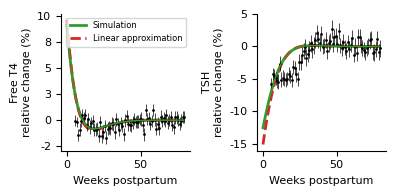

In [62]:
plt.figure(figsize=(4,2))
ax1,ax2 = plt.subplot(121),plt.subplot(122)
ax1.plot(xplot,y3_pred,c=def_color[2],lw=2,zorder=-5)
ax1.plot(xplot,y3_linear,c=def_color[3],lw=2,ls='--',zorder=-5)
ax1.legend(['Simulation','Linear approximation'],fontsize=6)

ax2.plot(xplot,y2_pred,c=def_color[2],lw=2,zorder=-5)
ax2.plot(xplot,y2_linear,c=def_color[3],lw=2,ls='--',zorder=-5)

ax1.plot(xplot,y3_pred,c=def_color[2],lw=1)
ax1.errorbar(xdat,ydat_y3,yerr_y3,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax1.set_xlabel('Weeks postpartum',fontsize=8)
ax1.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax2.plot(xplot,y2_pred,c=def_color[2],lw=1); 
ax2.errorbar(xdat,ydat_y2,yerr_y2,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax2.set_xlabel('Weeks postpartum',fontsize=8)
ax2.set_ylabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

remove_top_right_frame([ax1,ax2])
plt.tight_layout(); 
plt.show()

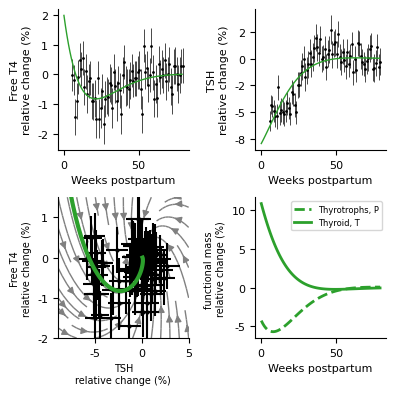

In [63]:
##### Fitting intial conditions and turnover rates
mdeqs_func = lambdify([P,T,ap,at],[mdeqs[0].args[1],mdeqs[1].args[1]])
ys_func    = lambdify([P,T],[ysols[0].args[1],ysols[1].args[1]])

def sim_mdeqs(y,t,ap,at):
    P,T = y
    return mdeqs_func(P,T,ap,at)

def obj_func(xdat,P0,T0,ap,at):
    msols = odeint(sim_mdeqs,[P0,T0],np.arange(0,80),args=(ap,at))
    ysols = ys_func(msols[xdat.astype(int),0],msols[xdat.astype(int),1])
    return np.array(ysols).flat[:]

ydat              = np.append(ydat_y2.values,ydat_y3.values)
bounds            = ((0.8,0.8,0,0), (1.2,1.2,1,1))
popts,pcov        = curve_fit(obj_func,xdat,ydat,maxfev = 100000, p0 = [0.97,1.2,0.12,0.12], bounds=bounds)

xplot             = np.arange(0,80,1).astype(int)
ypred             = obj_func(xplot,*popts); y2_pred = ypred[:len(xplot)]; y3_pred = ypred[len(xplot):]

def f_dt(Y,dt):
    y20, y30 = Y
    x20, x30 = y20+1,y30+1
    m10,m20  = np.array((nsolve([qst[X2]-x20,qst[X3]-x30],[P,T],[1,1]))).astype(float).flat[:]
    dm1,dm2  = mdeqs_func(m10,m20,popts[2],popts[3])*dt
    m11,m21  = m10+dm1, m20+dm2
    x21      = m11**(1/3) * m21**(-2/3)
    x31      = m11**(1/3) * m21**(1/3)
    return x21-x20, x31-x30

n_arrows = 10
y2_lim   = [-0.09, 0.05]
y3_lim   = [-0.02, 0.015]
y2_range = np.linspace(y2_lim[0], y2_lim[1], n_arrows)
y3_range = np.linspace(y3_lim[0], y3_lim[1], n_arrows)
Y2_, Y3_ = np.meshgrid(y2_range, y3_range)
v2, v3   = np.zeros(Y2_.shape), np.zeros(Y3_.shape)

for i in range(n_arrows):
    for j in range(n_arrows):
        yprime  = f_dt([Y2_[i, j], Y3_[i, j]], 1)
        v2[i,j] = yprime[0]
        v3[i,j] = yprime[1]
        
plt.figure(figsize=(4,4))
ax1,ax2,ax3,ax4 = plt.subplot(221),plt.subplot(222),plt.subplot(223),plt.subplot(224)

ax1.plot(xplot,y3_pred,c=def_color[2],lw=1)
ax1.errorbar(xdat,ydat_y3,yerr_y3,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax1.set_xlabel('Weeks postpartum',fontsize=8)
ax1.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax2.plot(xplot,y2_pred,c=def_color[2],lw=1); 
ax2.errorbar(xdat,ydat_y2,yerr_y2,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax2.set_xlabel('Weeks postpartum',fontsize=8)
ax2.set_ylabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='gray', linewidth=1)
ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2)
ax3.set_xlim(y2_lim)
ax3.set_ylim(y3_lim)
ax3.plot(y2_pred,y3_pred,lw=3,c=def_color[2],zorder=4)
ax3.set_xticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_xticks()])
ax3.set_yticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_yticks()])
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=7)
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=7)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))


msols = odeint(sim_mdeqs,[popts[0],popts[1]],xplot,args=(popts[2],popts[3])) ; P_pred = msols[xplot,0]; T_pred =msols[xplot,1]
ax4.plot(xplot,msols[:,0]-1,lw=2,ls='--',c=def_color[2])
ax4.plot(xplot,msols[:,1]-1,lw=2,c=def_color[2])
ax4.set_ylabel('functional mass \nrelative change (%)',fontsize=7)
ax4.set_xlabel('Weeks postpartum',fontsize=8)
ax4.legend(['Thyrotrophs, P','Thyroid, T'],fontsize=6)
remove_top_right_frame([ax1,ax2,ax3,ax4])
plt.tight_layout(); 
# plt.savefig('thyroid_fit_turnover_model.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

gland_mass_fit_pred = pd.DataFrame(np.array([y2_pred,y3_pred,P_pred,T_pred]).T,columns=['x2','x3','P','T'],index=xplot)

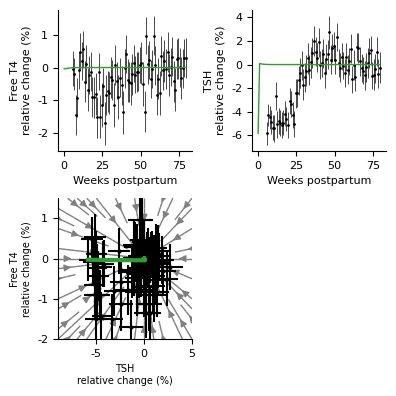

In [64]:
#### The minimal model without gland mass change
dx1      = b1/X3      - a1*X1  
dx2      = b2*P*X1/X3 - a2*X2       
dx3      = b3*T*X2    - a3*X3 
min_pars = {b1:1/6,b2:1/60,b3:1/(7*60*24),a1:1/6,a2:1/60,a3:1/(7*60*24),P:1,T:1}

minimal_xdeqs = Matrix([dx1,dx2,dx3]).subs(min_pars)
minimal_func  = lambdify([X1,X2,X3],minimal_xdeqs)

x2_ic = ydat_y2.iloc[0] + 1
x3_ic = ydat_y3.iloc[0] + 1
x1_ic = solve(dx1,X1)[0].subs(min_pars).subs(X3,x3_ic)

def sim_fast_eq(y,t):
    return minimal_func(*y).flat[:]

ics           = [x1_ic,x2_ic,x3_ic]
minimal_x_sol = odeint(sim_fast_eq,ics,xplot*60*24)

y2_pred = minimal_x_sol[:,1] - 1
y3_pred = minimal_x_sol[:,2] - 1

def f_dt(Y,dt):
    y20, y30 = Y
    x20, x30 = y20+1,y30+1
    m10,m20  = np.array((nsolve([qst[X2]-x20,qst[X3]-x30],[P,T],[1,1]))).astype(float).flat[:]
    dm1,dm2  = mdeqs_func(m10,m20,popts[2],popts[3])*dt
    m11,m21  = m10+dm1, m20+dm2
    x21      = 1**(1/3) * 1**(-2/3)
    x31      = 1**(1/3) * 1**(1/3)
    return x21-x20, x31-x30

n_arrows = 10
y2_lim   = [-0.09, 0.05]
y3_lim   = [-0.02, 0.015]
y2_range = np.linspace(y2_lim[0], y2_lim[1], n_arrows)
y3_range = np.linspace(y3_lim[0], y3_lim[1], n_arrows)
Y2_, Y3_ = np.meshgrid(y2_range, y3_range)
v2, v3   = np.zeros(Y2_.shape), np.zeros(Y3_.shape)

for i in range(n_arrows):
    for j in range(n_arrows):
        yprime  = f_dt([Y2_[i, j], Y3_[i, j]], 1)
        v2[i,j] = yprime[0]
        v3[i,j] = yprime[1]
    

plt.figure(figsize=(4,4))
ax1,ax2,ax3 = plt.subplot(221),plt.subplot(222),plt.subplot(223)
        
ax1.plot(xplot,y3_pred,c=def_color[2],lw=1)
ax1.errorbar(xdat,ydat_y3,yerr_y3,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax1.set_xlabel('Weeks postpartum',fontsize=8)
ax1.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax2.plot(xplot,y2_pred,c=def_color[2],lw=1); 
ax2.errorbar(xdat,ydat_y2,yerr_y2,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax2.set_xlabel('Weeks postpartum',fontsize=8)
ax2.set_ylabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='gray', linewidth=1)
ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2)
ax3.set_xlim(y2_lim)
ax3.set_ylim(y3_lim)
ax3.plot(y2_pred,y3_pred,lw=3,c=def_color[2],zorder=4)
ax3.set_xticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_xticks()])
ax3.set_yticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_yticks()])
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=7)
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=7)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

remove_top_right_frame([ax1,ax2,ax3,ax4])
plt.tight_layout();
plt.savefig('thyroid_fit_minimal_model.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

minimal_model_pred = pd.DataFrame(np.array([y2_pred,y3_pred,np.ones_like(y2_pred),np.ones_like(y2_pred)]).T,columns=['x2','x3','P','T'],index=xplot)

In [65]:
comparison_dfs = [minimal_model_pred,gland_mass_yael_pred,gland_mass_fit_pred]

fit_summery    = []
for i,df in enumerate(comparison_dfs):
    y2_pred= df['x2'].values
    y3_pred= df['x3'].values
    P_pred = df['P'].values
    T_pred = df['T'].values
    pearson_corr = stats.pearsonr(np.array([y2_pred[5:]] + [y3_pred[5:]]).flat[:],np.array([ydat_y2] + [ydat_y3]).flat[:])
    sse          = np.sum((y2_pred[5:] - ydat_y2)**2) + np.sum((y3_pred[5:] - ydat_y3)**2)
    fit_summery.append(list(pearson_corr) + [sse])
    
display(pd.DataFrame(fit_summery,columns=['pearson r','pval','sse'],index = ['Minimal model','Gland mass model\n(yael)','gland mass model\nfit turnvoer']))

pearson r          pval       sse
Minimal model                   -0.416542  1.146197e-07  0.051419
Gland mass model\n(yael)         0.670218  6.612756e-21  0.026035
gland mass model\nfit turnvoer   0.853207  1.113218e-43  0.012302

In [ ]:
popts_bs = []
for i in tqdm(range(1000)):
    ydat_y2_bs = ydat_y2 + np.random.randn(len(yerr_y2))*yerr_y2
    ydat_y3_bs = ydat_y3 + np.random.randn(len(yerr_y3))*yerr_y3
    ydat       = np.append(ydat_y2_bs.values,ydat_y3_bs.values)
    popts      = curve_fit(obj_func,xdat,ydat,maxfev = 100000, p0 = [0.97,1.2,0.12,0.12], bounds=bounds)[0]
    popts_bs.append(popts)
popt_df = pd.DataFrame(popts_bs,columns=['P0','T0','ap','at'])

print('T0',(np.array([np.percentile(popt_df.T0,50),np.percentile(popt_df.T0,5),np.percentile(popt_df.T0,95)]) - 1)*100)
print('P0',(np.array([np.percentile(popt_df.P0,50),np.percentile(popt_df.P0,5),np.percentile(popt_df.P0,95)]) - 1)*100)
print('at',np.array([np.percentile(7/popt_df['at'],50),np.percentile(7/popt_df['at'],5),np.percentile(7/popt_df['at'],95)]))
print('ap',np.array([np.percentile(7/popt_df['ap'],50),np.percentile(7/popt_df['ap'],5),np.percentile(7/popt_df['ap'],95)]))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def obj_func_full(xdat,P0,T0,ap,at):
    msols = odeint(sim_mdeqs,[P0,T0],np.arange(0,80),args=(ap,at))
    ysols = ys_func(msols[xdat.astype(int),0],msols[xdat.astype(int),1])
    return np.array(ysols).flat[:],np.array(msols).T.flat[:]

y2_bs = []
y3_bs = []
P_bs  = []
T_bs  = []
for popts in popts_bs:
    pred   = obj_func_full(xplot,*popts) 
    y2_bs.append(pred[0][:len(xplot)])
    y3_bs.append(pred[0][len(xplot):])
    P_bs.append(pred[1][:len(xplot)])
    T_bs.append(pred[1][len(xplot):])

y2_bs = np.array(y2_bs)
y3_bs = np.array(y3_bs)
P_bs = np.array(P_bs)
T_bs = np.array(T_bs)

In [ ]:
##### Plot for paper
plt.figure(figsize=(4.5,4))
ax1,ax2,ax3,ax4 = plt.subplot(221),plt.subplot(222),plt.subplot(223),plt.subplot(224)

gland_mass_fit_pred.x3.plot(ax=ax1,c=def_color[2],lw=2)
minimal_model_pred.x3.plot(ax=ax1,c=def_color[0],lw=2,zorder=-4)
ax1.errorbar(xdat,ydat_y3,yerr_y3,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax1.set_xlabel('Weeks postpartum',fontsize=8)
ax1.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=8)
ax1.set_xlim([0,80]); ax1.legend(['Gland mass model','Classic model'],fontsize=6)
ax1.fill_between(xplot,np.percentile(y3_bs,5,axis=0),np.percentile(y3_bs,95,axis=0),color=def_color[2],alpha=0.3)

gland_mass_fit_pred.x2.plot(ax=ax2,c=def_color[2],lw=2)
minimal_model_pred.x2.plot(ax=ax2,c=def_color[0],lw=2,zorder=-4)
ax2.plot(xplot,y2_pred,c=def_color[2],lw=1); 
ax2.errorbar(xdat,ydat_y2,yerr_y2,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax2.set_xlabel('Weeks postpartum',fontsize=8)
ax2.set_ylabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=8)
ax2.set_xlim([0,80])
ax2.fill_between(xplot,np.percentile(y2_bs,5,axis=0),np.percentile(y2_bs,95,axis=0),color=def_color[2],alpha=0.3)

(gland_mass_fit_pred['P']-1).plot(ax=ax4,c=def_color[2],lw=2,ls='--')
(gland_mass_fit_pred['T']-1).plot(ax=ax4,c=def_color[2],lw=2)
(minimal_model_pred-1).P.plot(ax=ax4,c=def_color[0],lw=2,zorder=-4)
ax4.set_xlim([0,80])
ax4.set_ylabel('Relative\nfunctional mass (%)')
ax4.set_xlabel('Weeks postpartum')
ax4.legend(['Thyrotrophs, P','Thyroid, T'],fontsize=6)
ax4.fill_between(xplot,np.percentile(P_bs-1,5,axis=0),np.percentile(P_bs-1,95,axis=0),color=def_color[2],alpha=0.3)
ax4.fill_between(xplot,np.percentile(T_bs-1,5,axis=0),np.percentile(T_bs-1,95,axis=0),color=def_color[2],alpha=0.3)

def f_dt(Y,dt):
    y20, y30 = Y
    x20, x30 = y20+1,y30+1
    m10,m20  = np.array((nsolve([qst[X2]-x20,qst[X3]-x30],[P,T],[1,1]))).astype(float).flat[:]
    dm1,dm2  = mdeqs_func(m10,m20,popts[2],popts[3])*dt
    m11,m21  = m10+dm1, m20+dm2
    x21      = m11**(1/3) * m21**(-2/3)
    x31      = m11**(1/3) * m21**(1/3)
    return x21-x20, x31-x30

n_arrows = 10
y2_lim   = [-0.09, 0.05]
y3_lim   = [-0.02, 0.015]
y2_range = np.linspace(y2_lim[0], y2_lim[1], n_arrows)
y3_range = np.linspace(y3_lim[0], y3_lim[1], n_arrows)
Y2_, Y3_ = np.meshgrid(y2_range, y3_range)
v2, v3   = np.zeros(Y2_.shape), np.zeros(Y3_.shape)

for i in range(n_arrows):
    for j in range(n_arrows):
        yprime  = f_dt([Y2_[i, j], Y3_[i, j]], 1)
        v2[i,j] = yprime[0]
        v3[i,j] = yprime[1]
ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='silver', linewidth=1)
ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='silver', linewidth=1)

yerr_y2__ = np.sqrt((yerr_y2**2).rolling(2).mean().iloc[1::2])
yerr_y3__ = np.sqrt((yerr_y3**2).rolling(2).mean().iloc[1::2])
ydat_y2__ = ydat_y2.rolling(2).mean().iloc[1::2]
ydat_y3__ = ydat_y3.rolling(2).mean().iloc[1::2]
ax3.errorbar(ydat_y2__,ydat_y3__,xerr=yerr_y2__,yerr=yerr_y3__,c='k',fmt='o',markersize=2.5,linewidth=1.5,alpha=0.4)

ax3.set_xlim(y2_lim)
ax3.set_ylim(y3_lim)
ax3.plot(gland_mass_fit_pred.x2,gland_mass_fit_pred.x3,lw=3,c=def_color[2],zorder=4)
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)')
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)')

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

remove_top_right_frame([ax1,ax2,ax3,ax4])
plt.tight_layout(); 
plt.savefig('M_4.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()

pearson correlation is increased to 0.9 when mergeing consecutive bins 

In [ ]:
xdat    = ydat_y3__.index
yerr_y2 = yerr_y2__
yerr_y3 = yerr_y3__
ydat_y2 = ydat_y2__
ydat_y3 = ydat_y3__

##### Fitting intial conditions and turnover rates
mdeqs_func = lambdify([P,T,ap,at],[mdeqs[0].args[1],mdeqs[1].args[1]])
ys_func    = lambdify([P,T],[ysols[0].args[1],ysols[1].args[1]])

def sim_mdeqs(y,t,ap,at):
    P,T = y
    return mdeqs_func(P,T,ap,at)

def obj_func(xdat,P0,T0,ap,at):
    msols = odeint(sim_mdeqs,[P0,T0],np.arange(0,80),args=(ap,at))
    ysols = ys_func(msols[xdat.astype(int),0],msols[xdat.astype(int),1])
    return np.array(ysols).flat[:]

ydat              = np.append(ydat_y2.values,ydat_y3.values)
bounds            = ((0.8,0.8,0,0), (1.2,1.2,1,1))
popts,pcov        = curve_fit(obj_func,xdat,ydat,maxfev = 100000, p0 = [0.97,1.2,0.12,0.12], bounds=bounds)

xplot             = np.arange(0,80,1).astype(int)
ypred             = obj_func(xplot,*popts); y2_pred = ypred[:len(xplot)]; y3_pred = ypred[len(xplot):]

def f_dt(Y,dt):
    y20, y30 = Y
    x20, x30 = y20+1,y30+1
    m10,m20  = np.array((nsolve([qst[X2]-x20,qst[X3]-x30],[P,T],[1,1]))).astype(float).flat[:]
    dm1,dm2  = mdeqs_func(m10,m20,popts[2],popts[3])*dt
    m11,m21  = m10+dm1, m20+dm2
    x21      = m11**(1/3) * m21**(-2/3)
    x31      = m11**(1/3) * m21**(1/3)
    return x21-x20, x31-x30

n_arrows = 10
y2_lim   = [-0.09, 0.05]
y3_lim   = [-0.02, 0.015]
y2_range = np.linspace(y2_lim[0], y2_lim[1], n_arrows)
y3_range = np.linspace(y3_lim[0], y3_lim[1], n_arrows)
Y2_, Y3_ = np.meshgrid(y2_range, y3_range)
v2, v3   = np.zeros(Y2_.shape), np.zeros(Y3_.shape)

for i in range(n_arrows):
    for j in range(n_arrows):
        yprime  = f_dt([Y2_[i, j], Y3_[i, j]], 1)
        v2[i,j] = yprime[0]
        v3[i,j] = yprime[1]
        
plt.figure(figsize=(4,4))
ax1,ax2,ax3,ax4 = plt.subplot(221),plt.subplot(222),plt.subplot(223),plt.subplot(224)

ax1.plot(xplot,y3_pred,c=def_color[2],lw=1)
ax1.errorbar(xdat,ydat_y3,yerr_y3,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax1.set_xlabel('Weeks postpartum',fontsize=8)
ax1.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax2.plot(xplot,y2_pred,c=def_color[2],lw=1); 
ax2.errorbar(xdat,ydat_y2,yerr_y2,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax2.set_xlabel('Weeks postpartum',fontsize=8)
ax2.set_ylabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax3.streamplot(Y2_, Y3_, v2, v3, density=0.5,color='gray', linewidth=1)
ax3.errorbar(ydat_y2,ydat_y3,xerr=yerr_y2,yerr=yerr_y3,c='k',fmt='o',markersize=2)
ax3.set_xlim(y2_lim)
ax3.set_ylim(y3_lim)
ax3.plot(y2_pred,y3_pred,lw=3,c=def_color[2],zorder=4)
ax3.set_xticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_xticks()])
ax3.set_yticklabels([np.round(tick*100,decimals=1) for tick in ax3.get_yticks()])
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=7)
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=7)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

msols = odeint(sim_mdeqs,[popts[0],popts[1]],xplot,args=(popts[2],popts[3])) ; P_pred = msols[xplot,0]; T_pred =msols[xplot,1]
ax4.plot(xplot,msols[:,0]-1,lw=2,ls='--',c=def_color[2])
ax4.plot(xplot,msols[:,1]-1,lw=2,c=def_color[2])
ax4.set_ylabel('functional mass \nrelative change (%)',fontsize=7)
ax4.set_xlabel('Weeks postpartum',fontsize=8)
ax4.legend(['Thyrotrophs, P','Thyroid, T'],fontsize=6)
remove_top_right_frame([ax1,ax2,ax3,ax4])
plt.tight_layout(); 
# plt.savefig('thyroid_fit_turnover_model.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

pearson_corr = stats.pearsonr(np.array([y2_pred[6::2]] + [y3_pred[6::2]]).flat[:],np.array([ydat_y2] + [ydat_y3]).flat[:])
print(pearson_corr)

## The entire HPT axis dynamics can be explained by the gland mass model with minimal assumptions 

In [ ]:
def get_relative_change_norm_baselines_stats(test):
    df       = get_value_at_quantile_stats(test)
    df['sd'] = df['error']*np.sqrt(df['n'])    
    mu_end   = np.sum(df.loc[70:]['n']*df.loc[70:]['value'])/(np.sum(df.loc[70:]['n']))
    mu_start = np.sum(df.loc[:-50]['n']*df.loc[:-50]['value'])/(np.sum(df.loc[:-50]['n']))
    v        = pd.concat([df['value'].loc[:0]/mu_start, df['value'].loc[0:]/mu_end]) - 1
    e        = pd.concat([df['error'].loc[:0]/mu_start, df['error'].loc[0:]/mu_end])
    return df.index,v,e,df['n']

In [ ]:
xdat,ydat_y2,yerr_y2,n_y2 = get_relative_change_norm_baselines_stats('TSH_THYROID_STIMULATING_HORMONE')
xdat,ydat_y3,yerr_y3,n_y3 = get_relative_change_norm_baselines_stats('T4_FREE')
xplot                     = np.arange(0,80,1).astype(int)

plt.figure(figsize=(6,2))
ax1,ax2 = plt.subplot(121),plt.subplot(122)

ax1.errorbar(xdat,ydat_y3,yerr_y3,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax1.set_xlabel('Weeks postpartum',fontsize=8)
ax1.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax2.errorbar(xdat,ydat_y2,yerr_y2,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax2.set_xlabel('Weeks postpartum',fontsize=8)
ax2.set_ylabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=8)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
[ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20) for ax in [ax1,ax2]]

remove_top_right_frame([ax1,ax2])
plt.tight_layout();
plt.show()

In [ ]:
# hCG values obtained from "Regulation of Maternal Thyroid during Pregnancy" by Glinoer (1990) 
# Values were sampled from fig 6. using 'WebPlotDigitizer'
hcg = np.array([0                , 0,
                5.481179403206124, 23.21957884416816,
                7.600308722452256, 35.10956518111368,
                9.562052169922506, 43.73043106415376,
                11.530574995567328, 35.07660697337268,
                13.6031873507233, 28.266773746075774,
                15.570250002607448, 19.025959803502325,
                17.542110368276678, 11.713826802532346,
                19.475901918042528, 9.098029808404334,
                21.567913724590365, 10.086776040634547,
                23.505460006883666, 8.980381522544036,
                25.544801259921346, 8.795565243692572,
                27.934688513647398, 9.530241241564887,
                29.525026335276745, 8.846045536561704,
                31.318119713388743, 9.669583537583826,
                33.45800435966164, 9.903211339292234,
                35.45260171674714, 11.731348887660488])

# Values were corrected by hand to approxmiate the data using simple interpolation
hcg = np.array([0                , 0 ,
                2                , 0 ,
                10               , 44,
                20               , 9 ,
                40               , 9])

hcg      = np.reshape(hcg,(int(len(hcg)/2),2))
hcg_func = interp1d(hcg[:,0],hcg[:,1],bounds_error =False,fill_value=9)

To simulate pregnancy we assumed an increasing challenge on thyroid hormone production, and hCG dynamics obtained from the literature

In [ ]:
def get_gestational_challenge(t,g,q):
    if t < 22*7*24:   # pre-pregnancy
        q_ = 1
        h_ = 0
    elif t < 60*7*24: # pregnancy  
        q_ = (1+q*((t-22*7*24)/(38*7*24))**4)
        h_ = hcg_func((t-22*7*24)/(7*24))
    else:             # post-partum
        q_ = 1
        h_ = 0
    return q_,g*h_

time       = np.arange(0,(22+38+80)*7*24,1)
challenges =  pd.DataFrame([get_gestational_challenge(t,0.3,0.3) for t in time],columns=['q','hcg'],index=time/(24*7)-60).astype(float)

plt.figure(figsize=(2,2))
ax1 = plt.subplot(111)
ax2 = ax1.twinx()


challenges.q.plot(ax=ax1,c=def_color[1])  ; ax1.set_ylabel('T4 challenge',fontsize=9,color=def_color[1]); ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_xlim([-60,80])
challenges.hcg.plot(ax=ax2,c=def_color[3]); ax2.set_ylabel('hCG',fontsize=9,color=def_color[3])         ; ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_xlim([-60,80])
ax1.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20)
ax1.set_xlabel('Weeks postpartum',fontsize=9); ax1.set_xticks(np.arange(-60,80,30))
remove_top_right_frame([ax1,ax2])
# plt.savefig('hpt_model_challenge.pdf',bbox_inches = 'tight',pad_inches=0.1); 
plt.show()

In [ ]:
q,g,h    = symbols('q,g,h',positive=True)
dx1      = b1/X3          - a1*X1  
dx2      = b2*P*X1/X3     - a2*X2       
dx3      = b3*T*(X2+h)    - q*a3*X3
dP       = P*(bp/X3       - ap)
dT       = T*(bt*(X2+h)   - at)

simp     = {a1:b1,a2:b2,a3:b3,bp:ap,bt:at}       
pars     = {b1:10,b2:1,b3:1/(7*24),ap:1/(31*24),at:1/(85*24)} # parameters on the time scale of 1 hour

all_odes_func = lambdify([X1,X2,X3,P,T,q,h],Matrix([dx1,dx2,dx3,dP,dT]).subs(simp).subs(pars))

def sim_all_odes(y,t,gland_mass_change=True,g=0.5/30,q=0.5):
    
    q_,h_             = get_gestational_challenge(t,g,q)
    X1,X2,X3,P,T      = y
    dx1,dx2,dx3,dP,dT = all_odes_func(X1,X2,X3,P,T,q_,h_).flat[:]
    
    if gland_mass_change:
        return np.array([dx1,dx2,dx3,dP,dT]).astype(float)
    else:
        return np.array([dx1,dx2,dx3,0,0]).astype(float)

ic       = nsolve(Matrix([dx1,dx2,dx3,dP,dT]).subs(simp).subs(pars).subs(q,1).subs(h,0),[X1,X2,X3,P,T],[1,1,1,1,1])
ic       = np.array(ic).astype(float).flat[:] 
time     = np.arange(0,(22+38+80)*7*24,1)

In [ ]:
x,tsh_data,e,n = get_relative_change_norm_baselines_stats('TSH_THYROID_STIMULATING_HORMONE')
x,t4_data,e,n  = get_relative_change_norm_baselines_stats('T4_FREE')

t4_data        = t4_data+1#.drop(index=[-1,1,3])
tsh_data       = tsh_data+1#.drop(index=[-1,1,3])

In [ ]:
def fit_brute_gland_mass(pars):
    g,q      = pars
    sim_res  = pd.DataFrame(odeint(sim_all_odes,ic,time,args=(True,g,q)),columns=['x1','x2','x3','P','T'],index=time/(24*7)-60)/ic
    tsh_pred = sim_res.x2.loc[tsh_data.index.values]
    t4_pred  = sim_res.x3.loc[t4_data.index.values]
    return np.sum((tsh_pred - tsh_data)**2) + np.sum((4*t4_pred - 4*t4_data)**2) # I weight t4 data to make the fit evan for both tests

def fit_brute_constant_glands(pars):
    g,q      = pars
    sim_res  = pd.DataFrame(odeint(sim_all_odes,ic,time,args=(False,g,q)),columns=['x1','x2','x3','P','T'],index=time/(24*7)-60)/ic
    tsh_pred = sim_res.x2.loc[tsh_data.index.values]
    t4_pred  = sim_res.x3.loc[t4_data.index.values]
    return np.sum((tsh_pred - tsh_data)**2) + np.sum((4*t4_pred - 4*t4_data)**2) # I weight t4 data to make the fit evan for both tests

g_range = (0,1)
q_range = (0,1)
bounds  = (g_range,q_range)

In [ ]:
best_pars_gland_mass= brute(fit_brute_gland_mass,bounds,Ns = 3) 
best_pars_constant  = brute(fit_brute_constant_glands,bounds,Ns = 3) 

In [ ]:
fit_res_gland_mass  = pd.DataFrame(odeint(sim_all_odes,ic,time,args=(True,best_pars_gland_mass[0],best_pars_gland_mass[1])),columns=['x1','x2','x3','m1','m2'],index=time/(24*7)-60)/ic - 1
fit_res_const_mass  = pd.DataFrame(odeint(sim_all_odes,ic,time,args=(False,best_pars_constant[0],best_pars_constant[1])),columns=['x1','x2','x3','m1','m2'],index=time/(24*7)-60)/ic - 1

In [ ]:
plt.figure(figsize=(8,6))
ax4,ax1,ax2,ax3= plt.subplot(345),plt.subplot(346),plt.subplot(347),plt.subplot(348)

ax1.errorbar(xdat,ydat_y3,yerr_y3,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax1.set_xlabel('Weeks postpartum',fontsize=8)
ax1.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=8)
(fit_res_const_mass).x3.plot(ax=ax1,c='steelblue',lw=2,zorder=5)
ax1.set_xlim([-60,80])
ax1.set_xticks(np.arange(-60,80,30))
ax1.set_title('Classic model')

ax2.errorbar(xdat,ydat_y2,yerr_y2,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax2.set_xlabel('Weeks postpartum',fontsize=8)
ax2.set_ylabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=8)
fit_res_const_mass.x2.plot(ax=ax2,c='steelblue',lw=2,zorder=5)
ax2.set_xlim([-60,80])
ax2.set_xticks(np.arange(-60,80,30))
ax2.set_title('Classic model')

ax3.plot(tsh_data.loc[-40:50]-1,t4_data.loc[-40:50]-1,c='k',lw=0.4)
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name']+'\nrelative change (%)')
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name']+'\nrelative change (%)' )
ax3.plot(fit_res_const_mass.x2,(fit_res_const_mass).x3,c='steelblue',zorder=5)
ax3.set_title('Classic model')
ax3.set_xlim([-0.25,0.25])


ax4t = ax4.twinx()
challenges.q.plot(ax=ax4,c=def_color[1],lw=2)   ; ax4.set_xticks([]); ax4.set_yticks([]); ax4.set_xlim([-60,80])
challenges.hcg.plot(ax=ax4t,c=def_color[3],lw=2); ax4t.set_xticks([]); ax4t.set_yticks([]); ax4t.set_xlim([-60,80])
ax4.set_ylim([ax4.get_ylim()[0],ax4.get_ylim()[1]*1.1])
ax4t.set_ylim([ax4t.get_ylim()[0],ax4t.get_ylim()[1]*1.1])
ax4.set_ylabel('Load',color='k'); 

custom_lines = [Line2D([0], [0], color=def_color[1], lw=2),
                Line2D([0], [0], color=def_color[3], lw=2)]

ax4.legend(custom_lines, ['T4 challenge', 'hCG'],fontsize=6)
ax4.set_xlabel('Weeks postpartum'); ax4.set_xticks(np.arange(-60,80,30))
[ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20) for ax in [ax1,ax2,ax4]]
remove_top_right_frame([ax1,ax2,ax3,ax4,ax4t])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

#######
ax4,ax1,ax2,ax3= plt.subplot(3,4,9),plt.subplot(3,4,10),plt.subplot(3,4,11),plt.subplot(3,4,12)

ax1.errorbar(xdat,ydat_y3,yerr_y3,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax1.set_xlabel('Weeks postpartum',fontsize=8)
ax1.set_ylabel(metadata.loc['T4_FREE']['Nice name'] + '\nrelative change (%)',fontsize=8)
fit_res_gland_mass.x3.plot(ax=ax1,c=def_color[2],lw=2,zorder=5)
ax1.set_xlim([-60,80])
ax1.set_xticks(np.arange(-60,80,30))
ax1.set_title('Gland-Mass model')

ax2.errorbar(xdat,ydat_y2,yerr_y2,c='k',lw=0.5,fmt='o',markersize=1,zorder=-4)
ax2.set_xlabel('Weeks postpartum',fontsize=8)
ax2.set_ylabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name'] + '\nrelative change (%)',fontsize=8)
fit_res_gland_mass.x2.plot(ax=ax2,c=def_color[2],lw=2,zorder=5)
ax2.set_xlim([-60,80])
ax2.set_xticks(np.arange(-60,80,30))
ax2.set_title('Gland-Mass model')

ax3.plot(tsh_data.loc[-40:50]-1,t4_data.loc[-40:50]-1,c='k',lw=0.4)
ax3.set_xlabel(metadata.loc['TSH_THYROID_STIMULATING_HORMONE']['Nice name']+'\nrelative change (%)')
ax3.set_ylabel(metadata.loc['T4_FREE']['Nice name']+'\nrelative change (%)')
ax3.plot(fit_res_gland_mass.x2,fit_res_gland_mass.x3,c=def_color[2],zorder=5)
ax3.set_title('Gland-Mass model')
ax3.set_xlim([-0.25,0.25])

fit_res_gland_mass.m1.plot(ax=ax4,c=def_color[2],ls='--',lw=2,zorder=5)
fit_res_gland_mass.m2.plot(ax=ax4,c=def_color[2],lw=2,zorder=5)
ax4.set_ylabel('Relative change (%)');
ax4.set_xlabel('Weeks postpartum');
ax4.legend(['P','T'],fontsize=6,bbox_to_anchor=(0.35, 0.3))
ax4.set_xlim([-60,80])
ax4.set_xticks(np.arange(-60,80,30))
ax4.set_title('Gland-Mass model')

[ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20) for ax in [ax1,ax2,ax4]]
remove_top_right_frame([ax1,ax2,ax3,ax4,ax4t])

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

plt.tight_layout()
plt.savefig('S_thyroid.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); 
plt.show()